# Machine Learning Assignment: Multivariate Regression on Track running data

## Notebook setup

### Libraries

In [1]:
#pip install --upgrade scikit-learn

In [2]:
# libraries
import os
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # Import resample

### Data import

In [3]:
# Import csv-file with summary of garmin activities

summary_csv_path = os.path.join('C:/Users/michel.marien_icarew/Documents/GitHub/Machine-learning/docs/', 'Garmin_activity_description.csv')

def import_csv(csv_path):
    ''' import of csv-files'''    

    with open(csv_path, 'r') as csv_file:
        garmin_activities_csv = pd.read_csv(csv_file,
                                        sep=';',
                                        encoding='utf-8')
        
    return garmin_activities_csv

garmin_act_summary = import_csv(summary_csv_path)
garmin_act_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Activiteittype              226 non-null    object 
 1   Datum                       226 non-null    object 
 2   Favoriet                    226 non-null    bool   
 3   Titel                       226 non-null    object 
 4   Afstand                     226 non-null    float64
 5   CalorieÃ«n                  226 non-null    object 
 6   Tijd                        226 non-null    object 
 7   Gem. HS                     226 non-null    object 
 8   Max. HS                     226 non-null    object 
 9   Training effect aeroob      226 non-null    object 
 10  Gem. loopcadans             226 non-null    object 
 11  Max. loopcadans             226 non-null    object 
 12  Gemiddeld tempo             226 non-null    object 
 13  Beste tempo                 226 non

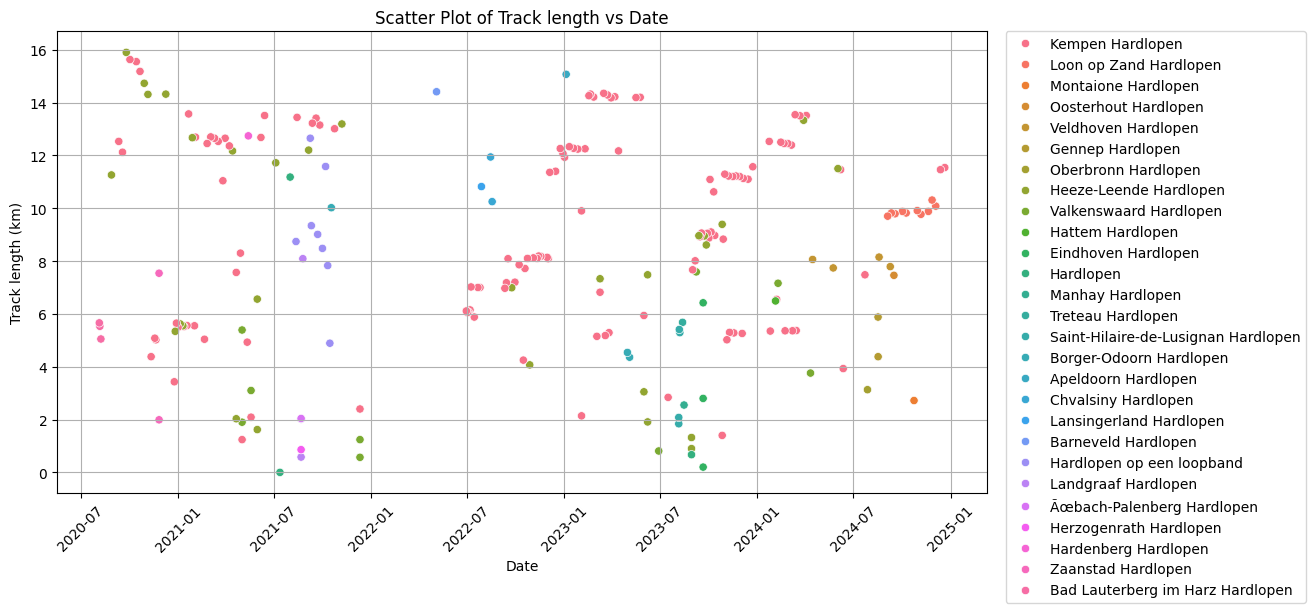

In [4]:
# data exploration plot

def plot_scatter(df):
    ''' Scatter plot function'''
    
    plt.figure(figsize=(12, 6))

    sns.scatterplot(x=pd.to_datetime(df['Datum'], format='%d-%m-%Y %H:%M'), y='Afstand', hue='Titel', data=df)

    plt.grid(True)

    plt.xlabel('Date')

    plt.ylabel('Track length (km)')

    plt.title('Scatter Plot of Track length vs Date')

    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 

    plt.xticks(rotation=45)

    plt.show()

plot_scatter(garmin_act_summary)

In [5]:
# Import csv-file with additional features

add_features_path = os.path.join('C:/Users/michel.marien_icarew/Documents/GitHub/Machine-learning/docs/', 'Additional_features.csv')

garmin_act_addfeatures = import_csv(add_features_path)

garmin_act_addfeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ï»¿datum         216 non-null    object 
 1   plaats           216 non-null    object 
 2   afstand          216 non-null    float64
 3   addfeat_asphalt  216 non-null    float64
 4   addfeat_forest   216 non-null    float64
 5   addfeat_dunes    216 non-null    float64
 6   addfeat_temp     216 non-null    float64
 7   addfeat_sky      216 non-null    object 
 8   addfeat_windsp   216 non-null    int64  
 9   addfeat_winddir  216 non-null    object 
 10  addfeat_humid    216 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 18.7+ KB


## Data preprocessing

### Data preprocessing garmin summary-file

In [6]:
# Reduce titel column to location only and drop rows with no location
def remove_act_from_titel(df):
    ''' remove activity from titel-column and drop rows without titel'''

    df.loc[:, 'Titel'] = df['Titel'].str.replace('hardlopen', '', case=False).str.strip()

    df.loc[:, 'Titel'] = df['Titel'].str.replace('  ', ' ')

    df = df[df['Titel'].notna() & (df['Titel'] != '')].reset_index(drop=True)

    return df

# Drop dependent and uninformative columns
def drop_cols(df, cols_to_drop):
    ''' general function for dropping cols '''

    df = df.drop(cols_to_drop,axis=1)

    return df

# Convert duration and tempo to seconds
def convert_duration(df):
    ''' convert duration and tempo to seconds '''

    df['Gemiddeld tempo'] = pd.to_timedelta('00:' + df['Gemiddeld tempo'])

    df['Gemiddeld tempo'] = df['Gemiddeld tempo'].dt.total_seconds()

    df['Verstreken tijd'] = pd.to_timedelta(df['Verstreken tijd']).dt.total_seconds()

    return df

# Convert columns to numeric
def convert_numeric(df, num_cols):
    '''Convert columns to numeric and round to 2 decimals '''

    for col in num_cols:
        df[col] = df[col].apply(lambda x: round(float(str(x).replace(',', '.').strip()), 2))

    return df

# Convert date columns
def convert_date(df, date_cols):
    ''' convert date column to date''' 

    df['Datum'] = pd.to_datetime(df['Datum'], format='%d-%m-%Y %H:%M')

    return df

# Convert data headers
def convert_colheaders(df):
    ''' convert colheaders to lowercase and remove punctuation''' 

    df.columns = (
        df.columns
        .str.lower()
        .str.translate(str.maketrans('', '', string.punctuation))
        .str.replace(' ', '_'))

    return df

# Selection of columns to drop and which to convert
date_cols = ['Datum']

num_cols = ['Totale stijging']

drop_columns = ['Activiteittype', 'Favoriet', 'CalorieÃ«n','Decompressie','Training Stress ScoreÂ®', 'Gem. vermogen', 'Gem. HS', 'Max. HS',
             'Max. vermogen','Beste rondetijd', 'Aantal ronden','Minimum hoogte', 'Maximum hoogte','Normalized PowerÂ® (NPÂ®)',
             'Gem. staplengte','Gemiddelde verticale ratio', 'Gem. verticale oscillatie' ,'Training effect aeroob','Beste tempo', 
             'Tijd bewogen', 'Gem. grondcontacttijd', 'Tijd','Gem. GAP','Gem. loopcadans','Max. loopcadans', 'Totale daling']


# Preprocess garmin summary file
def prep_garmin_summary(df,cols_to_drop,num_cols, date_cols):
    ''' apply preprocessing functions to imported garmin activities file'''

    df['Afstand'] = df['Afstand'].round(2)

    df = df.loc[df['Activiteittype'] == 'Hardlopen']  

    df.replace("--", np.nan, inplace=True)

    df = remove_act_from_titel(df)

    df = convert_duration(df)

    df = convert_numeric(df, num_cols)

    df = drop_cols(df, cols_to_drop)

    df = convert_date(df, date_cols)

    df = convert_colheaders(df)

    df = df.reset_index(drop=True)

    return df

garmin_activities_cln = prep_garmin_summary(garmin_act_summary, drop_columns, num_cols, date_cols)

garmin_activities_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datum            215 non-null    datetime64[ns]
 1   titel            215 non-null    object        
 2   afstand          215 non-null    float64       
 3   gemiddeld_tempo  215 non-null    float64       
 4   totale_stijging  197 non-null    float64       
 5   verstreken_tijd  215 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 10.2+ KB


C:\Users\michel.marien_icarew\AppData\Local\Temp\ipykernel_12396\1517476944.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace("--", np.nan, inplace=True)


In [7]:
# Preprocessing data frame with garmin activity summary

# Combine separate recordings of the same track
def combine_tracks(df, sum_columns, avg_columns, max_columns):
    ''' combine loose recordings of the same track''' 

    df = df.sort_values(by='datum').reset_index(drop=True)
    
    df['time_diff'] = df['datum'].diff()

    def merge_rows(df):

        groups = (df['time_diff'] >= pd.Timedelta(hours=2.5)).cumsum()  # Group by time difference
        
        def agg_func(group):
            
            result = group.iloc[0].copy()
            
            for col in sum_columns:
                result[col] = group[col].sum()
            
            for col in avg_columns:
                result[col] = group[col].mean()
            
            for col in max_columns:
                result[col] = group[col].max()

            return result

        return df.groupby(groups).apply(agg_func).reset_index(drop=True)

    while True:  # Loop until no more changes
        previous_length = len(df)
        df = merge_rows(df)
        if len(df) == previous_length:
            break       
    
    df.drop('time_diff', axis=1, inplace=True)

    df.reset_index(drop=True)

    return df

# Calculate speed
def calculate_speed(df):
    ''' calculate speed in km/h '''

    df['tempo_km/h'] = 3600 / df['gemiddeld_tempo']

    df['tempo_km/h'] = round(df['tempo_km/h'],3)

    return df

# Remove tracks shorter than 2.5 km
def remove_bad_tracks(df):
    ''' remove tracks shorter than 2.5 km'''

    df= df[df['afstand'] > 2.5]

    return df

# Remove first tracks
def remove_first_tracks(df):
    ''' remove tracks that are run for the first time '''

    df = df[df.groupby('titel')['titel'].transform('count') > 2]

    #print ('remove_first_tracks not active yet')

    return df

# Combine preprocessing functions
def combine_prep(df, sum_columns, avg_columns, max_columns, cols_to_drop):
    ''' Apply preprocessing functions'''

    df = combine_tracks(df, sum_columns, avg_columns, max_columns)

    df = remove_bad_tracks(df)

    df = remove_first_tracks(df)

    df = calculate_speed(df)

    df = df.drop(cols_to_drop,axis=1)

    df = df.reset_index(drop=True) 

    return df

### Apply preprocessing functions
sum_columns = ['afstand', 'totale_stijging', 'verstreken_tijd']
avg_columns = ['gemiddeld_tempo']
max_columns = []
keep_first_row_columns = ['datum', 'titel', 'tracklengths']

add_drop_cols = ['verstreken_tijd', 'gemiddeld_tempo']

garmin_activities_prep = combine_prep(garmin_activities_cln, sum_columns, avg_columns, max_columns, add_drop_cols)
garmin_activities_prep.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datum            175 non-null    datetime64[ns]
 1   titel            175 non-null    object        
 2   afstand          175 non-null    float64       
 3   totale_stijging  175 non-null    float64       
 4   tempo_km/h       175 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 7.0+ KB


In [8]:
# Preprocessing data frame with additional features

def prep_addfeatures(df, num_cols):
    ''' preprocess columns of the dataframe with additional features '''    
        
    df = df.rename(columns={'ï»¿datum': 'datum'}) 

    df['datum'] = pd.to_datetime(df['datum'], format='%d-%m-%Y %H:%M')    

    for col in num_cols:

        df[col] = pd.to_numeric(df[col])
      
    return df

### Apply preprocessing function

num_cols = ['afstand', 'addfeat_asphalt', 'addfeat_forest', 'addfeat_dunes','addfeat_temp','addfeat_windsp','addfeat_humid']  

garmin_addfeatures_prep = prep_addfeatures(garmin_act_addfeatures, num_cols)
garmin_addfeatures_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datum            216 non-null    datetime64[ns]
 1   plaats           216 non-null    object        
 2   afstand          216 non-null    float64       
 3   addfeat_asphalt  216 non-null    float64       
 4   addfeat_forest   216 non-null    float64       
 5   addfeat_dunes    216 non-null    float64       
 6   addfeat_temp     216 non-null    float64       
 7   addfeat_sky      216 non-null    object        
 8   addfeat_windsp   216 non-null    int64         
 9   addfeat_winddir  216 non-null    object        
 10  addfeat_humid    216 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 18.7+ KB


## Data exploration

### Garmin activities summary data frame

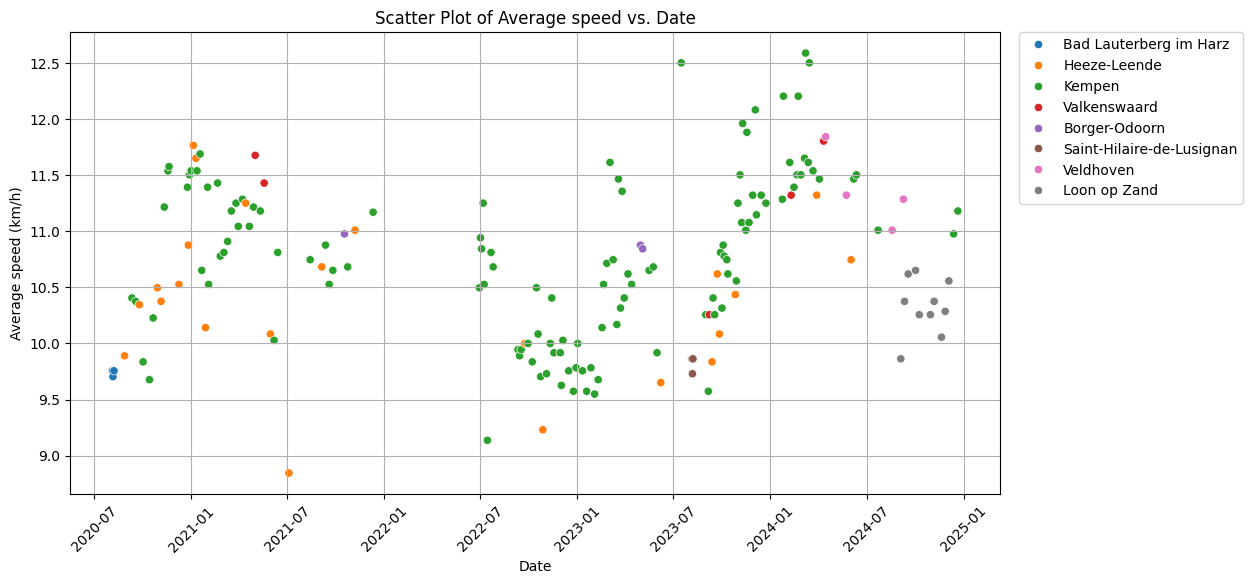

In [9]:
def plot_scatter(df):
    ''' Scatter plot function'''

    plt.figure(figsize=(12, 6))

    sns.scatterplot(x='datum', y='tempo_km/h', hue='titel', data=df)

    plt.grid(True)

    plt.xlabel('Date')

    plt.ylabel('Average speed (km/h)')

    plt.title('Scatter Plot of Average speed vs. Date')

    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 

    plt.xticks(rotation=45)
    
    plt.show()

plot_scatter(garmin_activities_prep)

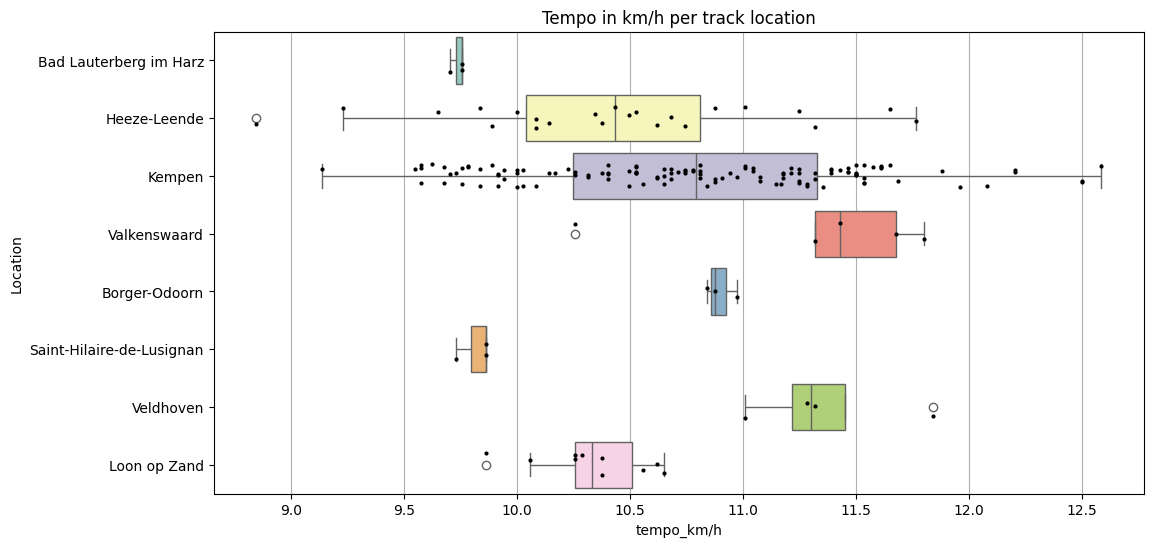

In [10]:
# Boxplot of track average speed per location
def plot_boxplot(df):
    ''' Box plot function'''
    
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    
    plt.grid(True)
    
    sns.boxplot(y='titel', x='tempo_km/h', data=df, hue='titel', palette="Set3", dodge=False)
    
    sns.stripplot(y='titel', x='tempo_km/h', data=df, color='black', size=3, jitter=0.2, dodge=False)  # Add individual data points

    plt.title("Tempo in km/h per track location")
    
    plt.ylabel("Location")
    
    plt.xlabel('tempo_km/h')
    
    #plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 
    
    plt.show()

plot_boxplot(garmin_activities_prep)

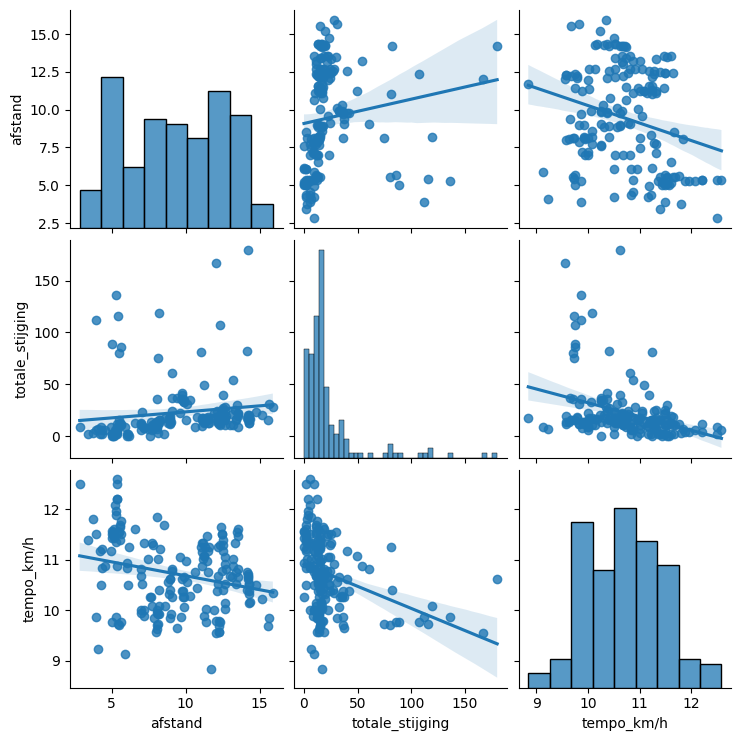

In [11]:
# Pairplot of garmin activities summary data frame
def plot_pairplot(df):
    ''' pair-plot of the numeric columns of df'''

    sns.pairplot(df, kind="reg")

    plt.show()

plot_pairplot(garmin_activities_prep)

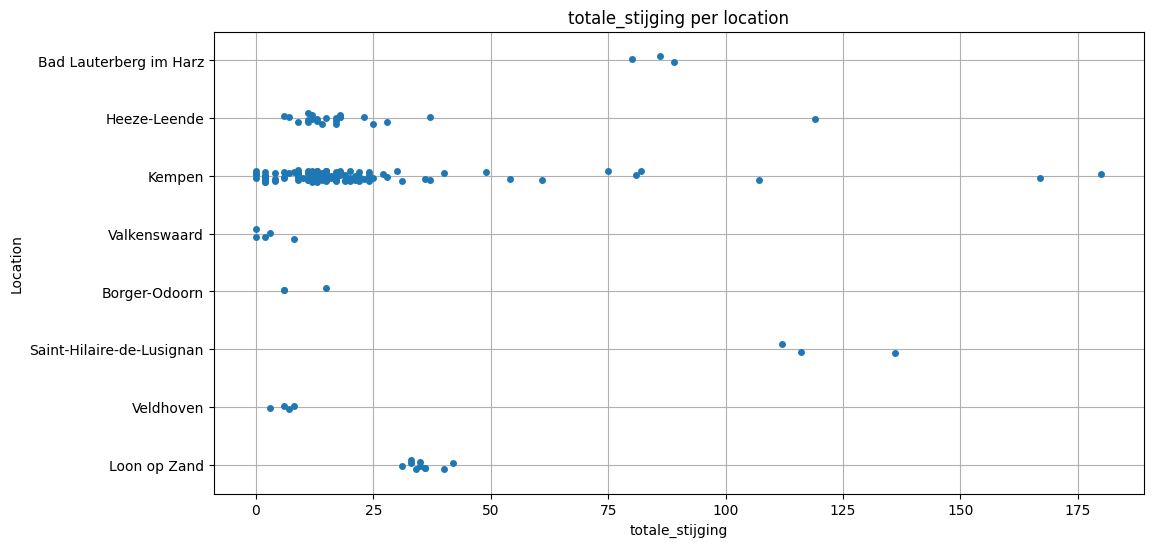

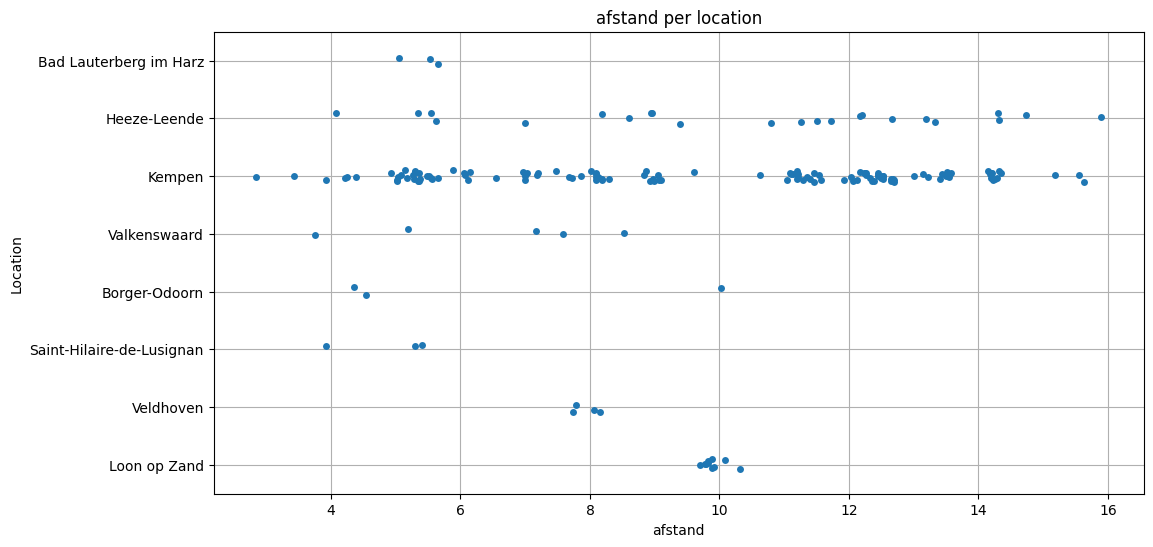

In [12]:
# Pairplot of garmin activities summary data frame
def plot_stripplot(df,y_col, x_col):
    ''' stripplot of x_col vs y_col'''

    plt.figure(figsize=(12, 6))

    sns.stripplot(y = x_col, x = y_col, data=df)

    plt.title(f"{y_col} per location") 

    plt.grid(True)

    plt.ylabel("Location")

    plt.xlabel(y_col)

    #plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    plt.show()

plot_stripplot(garmin_activities_prep, 'totale_stijging', 'titel')

plot_stripplot(garmin_activities_prep, 'afstand', 'titel')


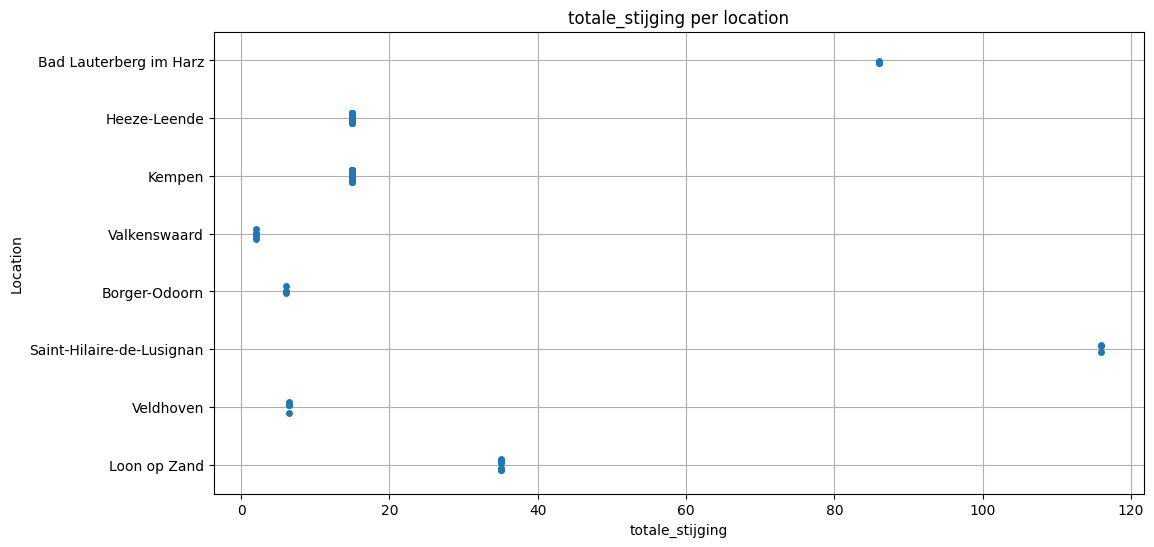

In [13]:
# removing outliers for 'totale stijging' Course files
def change_to_median(df, col_to_median, group_col):
    ''' values in col_to_median in df are changed to median value based on group_col'''
    
    for col in col_to_median:
        
        df[col] = df.groupby(group_col)[col].transform('median') 

    return df

### apply function
col_to_median = ['totale_stijging']
group_col = ['titel']

garmin_activities_prep = change_to_median(garmin_activities_prep, col_to_median, group_col)

plot_stripplot(garmin_activities_prep, 'totale_stijging', 'titel')

In [14]:
garmin_activities_prep

datum                   titel  afstand  totale_stijging  \
0   2020-08-04 17:04:00  Bad Lauterberg im Harz     5.66             86.0   
1   2020-08-05 17:19:00  Bad Lauterberg im Harz     5.53             86.0   
2   2020-08-07 17:15:00  Bad Lauterberg im Harz     5.05             86.0   
3   2020-08-27 16:47:00            Heeze-Leende    11.26             15.0   
4   2020-09-10 12:35:00                  Kempen    12.53             15.0   
..                  ...                     ...      ...              ...   
170 2024-11-19 16:06:00            Loon op Zand     9.88             35.0   
171 2024-11-26 15:56:00            Loon op Zand    10.31             35.0   
172 2024-12-03 15:56:00            Loon op Zand    10.08             35.0   
173 2024-12-12 13:54:00                  Kempen    11.46             15.0   
174 2024-12-20 15:38:00                  Kempen    11.54             15.0   

     tempo_km/h  
0         9.756  
1         9.704  
2         9.756  
3         9.890  
4        10.405  
..          ...  
170      10.056  
171      10.286  
172      10.557  
173      10.976  
174      11.180  

[175 rows x 5 columns]

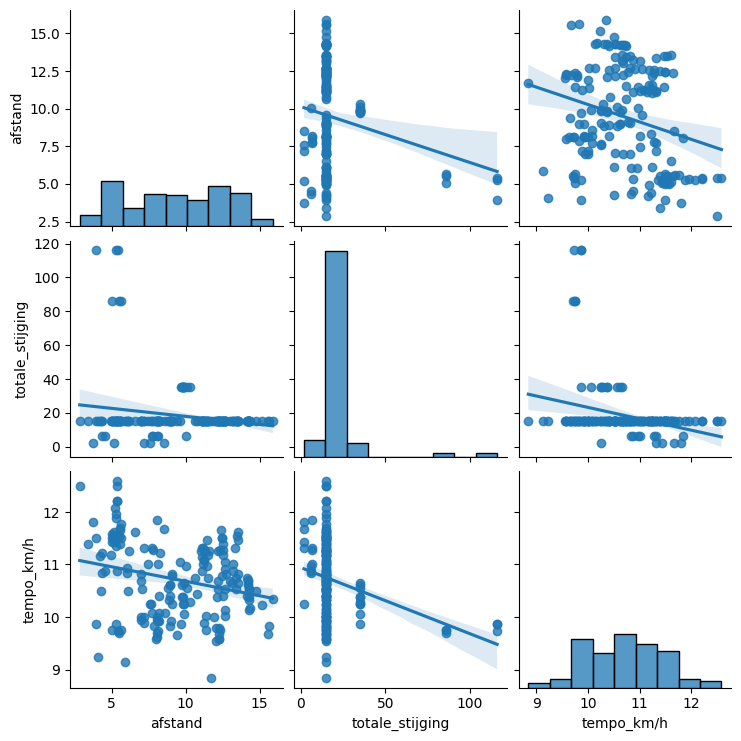

In [15]:
# Pairplot of garmin_activities_prep data frame
plot_pairplot(garmin_activities_prep)

### Garmin additional features data frame

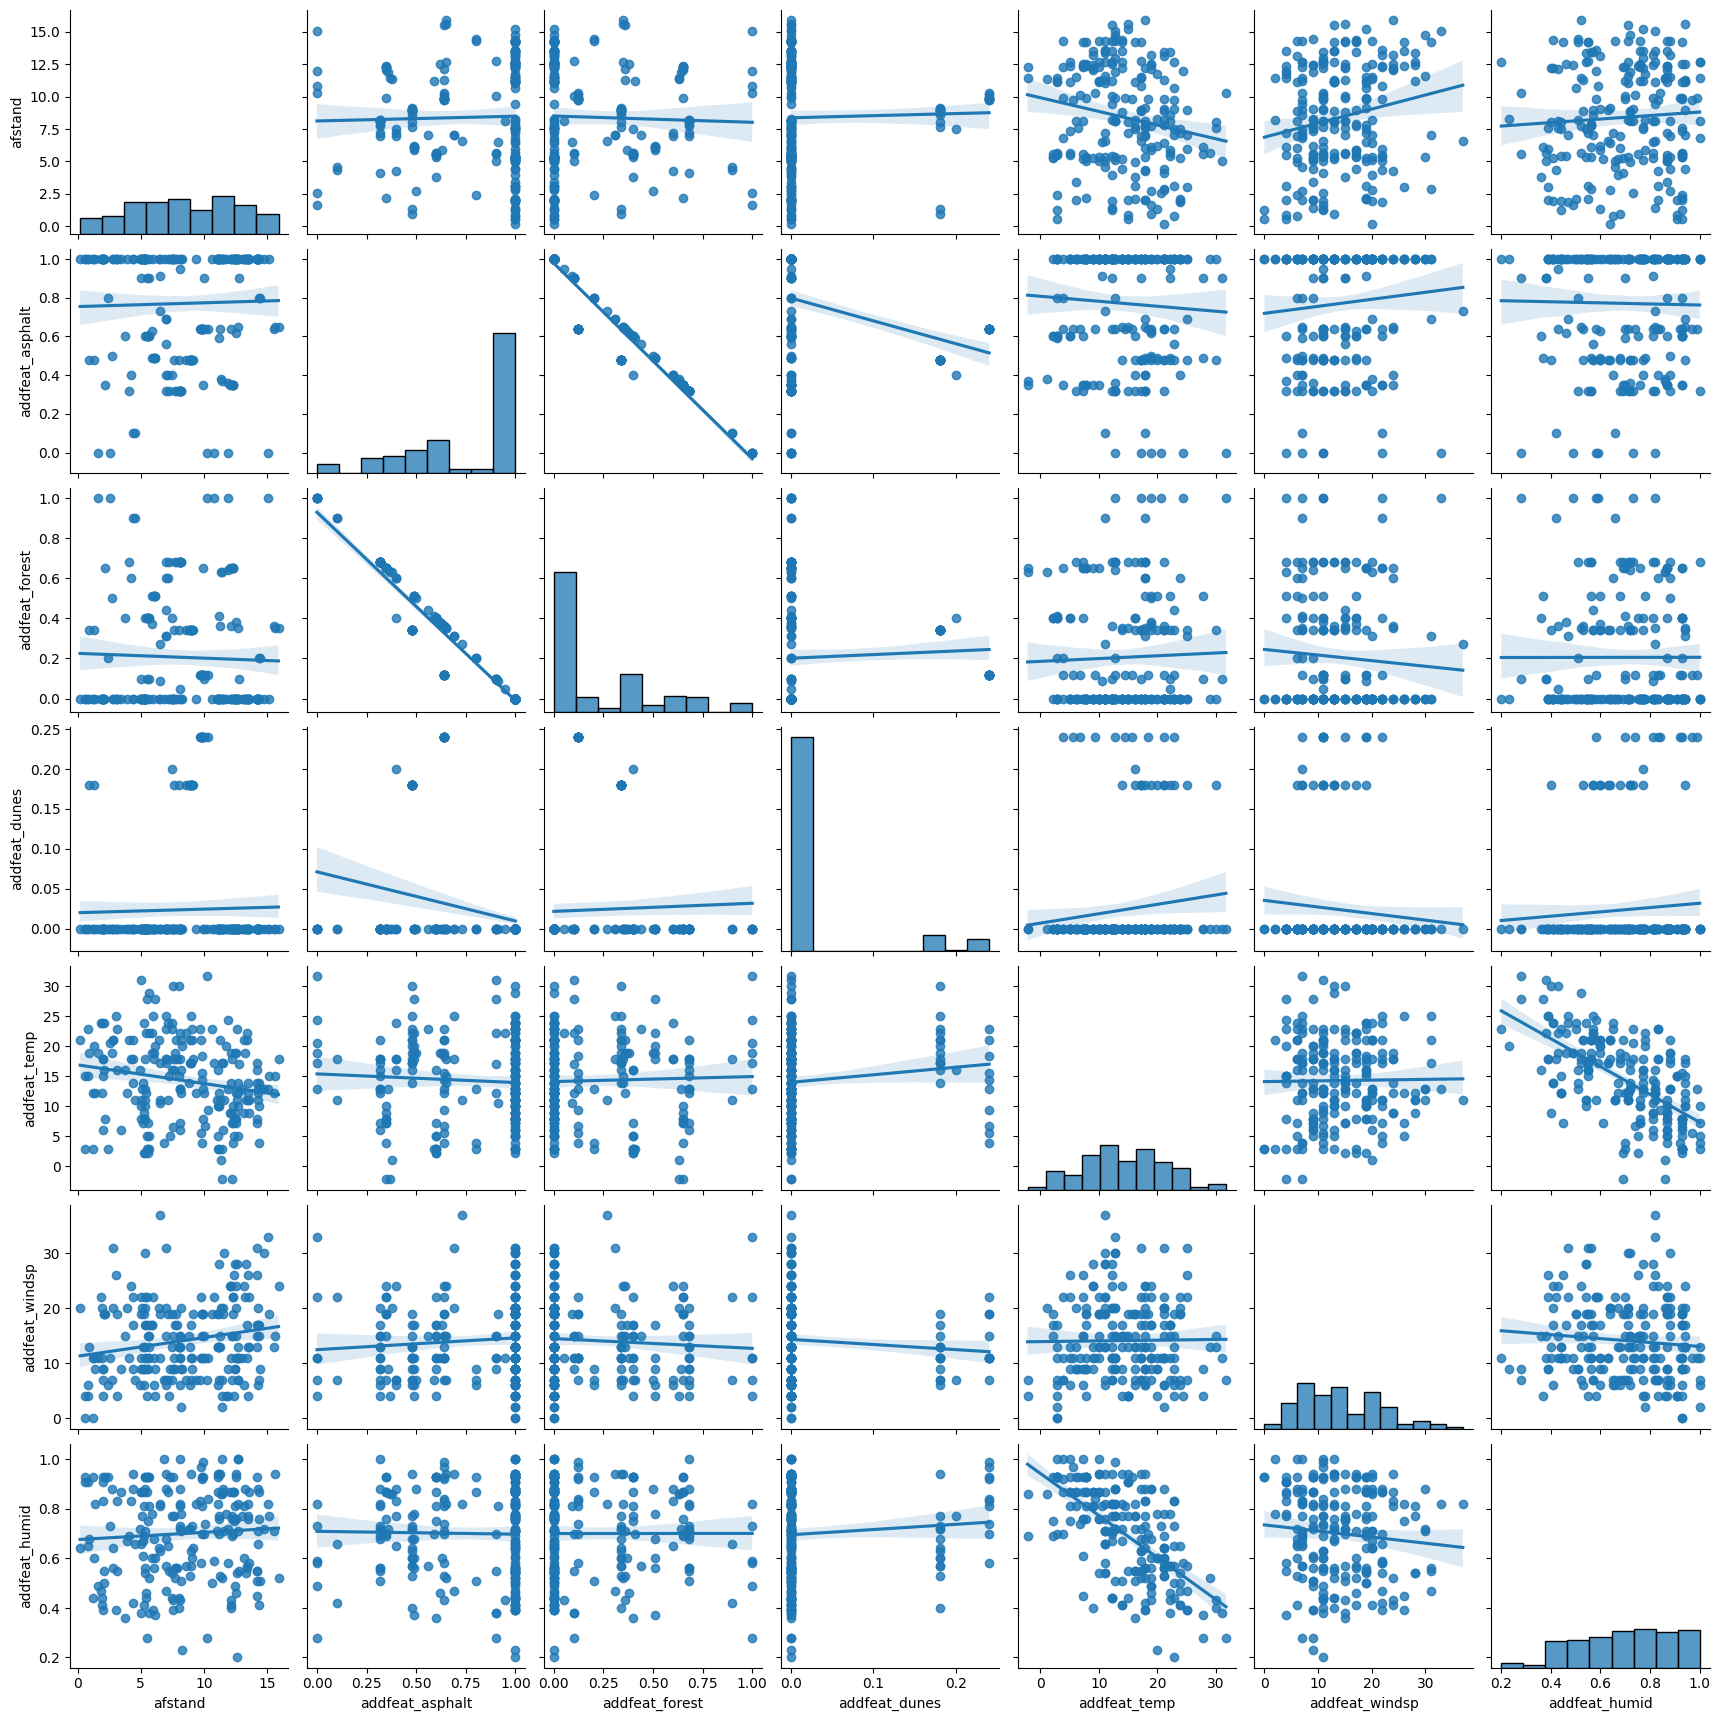

In [16]:
# Pairplot of garmin additional features data frame
plot_pairplot(garmin_addfeatures_prep)

## Regression analysis 1: Location based regression

### Prepare dataset for regression analysis

In [17]:
garmin_activities_prep.head()

datum                   titel  afstand  totale_stijging  \
0 2020-08-04 17:04:00  Bad Lauterberg im Harz     5.66             86.0   
1 2020-08-05 17:19:00  Bad Lauterberg im Harz     5.53             86.0   
2 2020-08-07 17:15:00  Bad Lauterberg im Harz     5.05             86.0   
3 2020-08-27 16:47:00            Heeze-Leende    11.26             15.0   
4 2020-09-10 12:35:00                  Kempen    12.53             15.0   

   tempo_km/h  
0       9.756  
1       9.704  
2       9.756  
3       9.890  
4      10.405

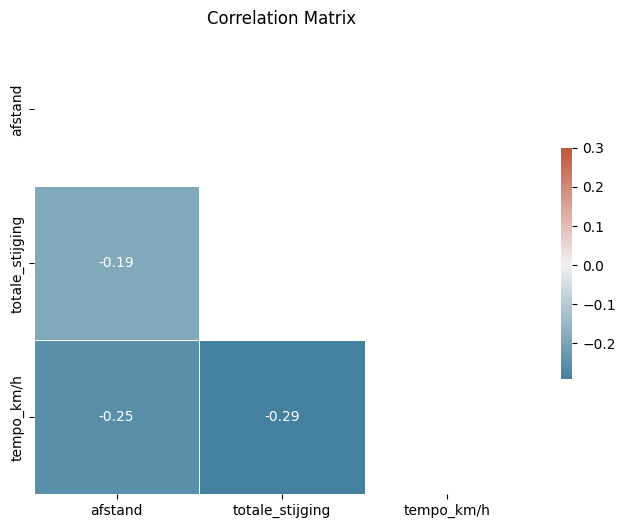

afstand  totale_stijging  tempo_km/h
afstand            1.000           -0.188      -0.252
totale_stijging   -0.188            1.000      -0.291
tempo_km/h        -0.252           -0.291       1.000

In [18]:
# correlation plot
def correlation_plot(df, non_num_cols):
    ''' create correlation heatmap'''

    matrix_cor = df.drop(non_num_cols, axis=1).corr().round(3)

    plt.figure(figsize=(8, 6))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    mask = np.triu(np.ones_like(matrix_cor, dtype=bool))

    sns.heatmap(matrix_cor,  cmap = cmap, vmax=.3, center=0, square=False, 
                linewidths=.5, cbar_kws={"shrink": .5}, mask = mask, annot=True)
    
    plt.title("Correlation Matrix")
    
    plt.show()

    return matrix_cor


# Create correlation plot
drop_cols = ['datum', 'titel']

df_correlation = correlation_plot(garmin_activities_prep, drop_cols)

df_correlation

### Regression analysis

In [19]:
# Filer data set based on correlation threshold
def filter_dataset(df, cor_matrix, target_column, corr_threshold):
    ''' filter df columns based on the corr_threshold for the target_column in cor_matrix'''

    filtered_cols = [col for col in cor_matrix.columns if abs(cor_matrix[col][target_column]) > corr_threshold and col != target_column]
    
    filtered_cols.append('tempo_km/h')

    df_filtered = df[filtered_cols]

    return df_filtered


# Normalize data
def normalize_data(df):
    ''' normalize data in df '''

    scaler = MinMaxScaler()

    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    return df_normalized

# Combine functions
def create_reg_dataset(df, cor_matrix, target_column, corr_treshold):
    ''' Combine normalizing functions'''

    df = filter_dataset(df, cor_matrix, target_column, corr_treshold)

    df = normalize_data(df)

    return df

### Apply functions
corr_treshold = 0.19
target_column = 'tempo_km/h'

loc_based_multivar_reg = create_reg_dataset(garmin_activities_prep, df_correlation, target_column, corr_treshold)

loc_based_multivar_reg.head()

afstand  totale_stijging  tempo_km/h
0  0.215926         0.736842    0.243453
1  0.205972         0.736842    0.229556
2  0.169219         0.736842    0.243453
3  0.644717         0.114035    0.279262
4  0.741960         0.114035    0.416889

In [20]:
# Create multivariate regression models

# Create bins on target variable for stratification
def _create_bins(y, n_bins=10):
    ''' Create bins on target variable for stratification '''

    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbd.fit_transform(y.values.reshape(-1, 1)).ravel()

    return y_binned

#
def _resample_within_bins(combined_data, y_binned, random_state=1):
    ''' Performs resampling within each bin '''

    unique_bins = np.unique(y_binned)
    resampled_data = []
    for bin_val in unique_bins:
        bin_indices = np.where(y_binned == bin_val)[0]
        bin_data = combined_data[bin_indices]
        resampled_bin = resample(bin_data, n_samples=len(bin_indices), random_state=random_state)
        resampled_data.append(resampled_bin)

    return resampled_data

def stratified_resample(X, y, n_bins=10, random_state=1):
    ''' Perform stratified resampling for regression problems by binning the target variable '''
    
    y_binned = _create_bins(y, n_bins)
    combined_data = np.column_stack([X, y])

    resampled_data = _resample_within_bins(combined_data, y_binned, random_state)
    resampled_combined = np.vstack(resampled_data)
    np.random.shuffle(resampled_combined)
    X_resampled = resampled_combined[:, :-1]
    y_resampled = resampled_combined[:, -1]
    
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns, index=X.index)  
    y_resampled = pd.Series(y_resampled, name=y.name, index=y.index)

    return X_resampled, y_resampled

# Data preparation for regression
def _prepare_data(df, target_column):
    ''' Data preparation of regression analysis '''

    X = df.drop(columns=[target_column])
    y = df[target_column]

    return X, y

# Polynomial features
def _create_polynomial_features(X_train, X_val, X_test, degree):
    ''' Creates polynomial features for the given datasets, including feature names '''

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    X_train_poly = poly.fit_transform(X_train)
    X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_train.index)

    X_val_poly = poly.transform(X_val)
    X_val_poly = pd.DataFrame(X_val_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_val.index)  
    
    X_test_poly = poly.transform(X_test)
    X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_test.index)  
    
    return X_train_poly, X_val_poly, X_test_poly

# Creating evaluation visualisations
def plot_model_performance(y, y_test, y_test_pred, degree):
    '''Creates and displays the actual vs predicted and residual plots with index '''
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted (Degree {degree})')
    plt.legend()
    
    for i, (actual, pred) in enumerate(zip(y_test, y_test_pred)):
        plt.annotate(y_test.index[i], (actual, pred), textcoords="offset points", xytext=(0,10), ha='center') 

    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, label='Test')
    plt.axhline(y=0, color='k', linestyle='--')
    
    for i, (pred, resid) in enumerate(zip(y_test_pred, y_test - y_test_pred)):
        plt.annotate(y_test.index[i], (pred, resid), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot (Degree {degree})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Model training
def _train_model(X_train_poly, y_train):
    ''' Model training '''

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    return model

# Model evaluation
def _evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, k=5):
    ''' Evaluates the model using cross-validation and calculates performance metrics '''

    train_r2 = model.score(X_train_poly, y_train)
    val_r2 = model.score(X_val_poly, y_val)
    test_r2 = model.score(X_test_poly, y_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train_poly)))
    val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val_poly)))
    test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_poly)))
    
    return {'Train R2': train_r2, 'Validation R2': val_r2, 'Test R2': test_r2, 'Train RMSE': train_rmse, 'Validation RMSE': val_rmse, 'Test RMSE': test_rmse}

# Application of the training and evaluation functions
def _train_and_evaluate_model(X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, degree, k=5):  # Add degree as input
    ''' Training, evaluating and plotting of the regression model '''

    model = _train_model(X_train_poly, y_train)
    metrics = _evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, k)

    y_test_pred = model.predict(X_test_poly)
    plot_model_performance(y_train, y_test, y_test_pred, degree)

    return metrics


In [21]:
# Combine all regression analysis subfunctions for polynomial regression with cross-validation and stratification
def run_multivariate_analysis(df, target_column, degrees=[1,2,3], k=5, train_size=0.75, val_size=0.15, test_size=0.15, n_bins=10, random_state=10):
    ''' Apply subfuctions for polynomial regression with cross-validation and stratification '''

    X, y = _prepare_data(df, target_column)
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (val_size + test_size), random_state=random_state)
    
    results = []

    for degree in degrees:

        X_train_poly, X_val_poly, X_test_poly = _create_polynomial_features(X_train, X_val, X_test, degree)
        model_results = _train_and_evaluate_model(X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, degree, k) 
        results.append({'Degree': degree, **model_results}) 

    return pd.DataFrame(results)

In [22]:
# Declaration of the Hyperparameters

degrees = [1, 2, 3]                             # Polynomial degrees to be tested
random_states = [100, 200, 300, 400, 500]       # Fixed random states
target_column = 'tempo_km/h'                    # Target variable
k_folds = 10                                    # Number of folds for cross validation
train_size = 0.7                                # Percentage of data set to be used for training of the models
val_size = 0.15                                 # Percentage of data set to be used for validation of the models
test_size = 0.15                                # Percentage of data set to be used for testing of the models

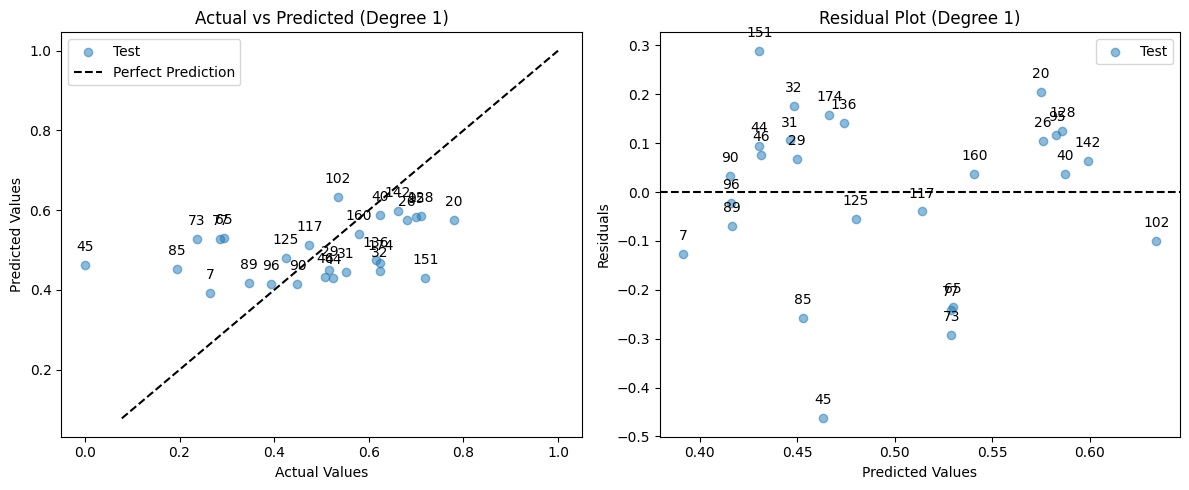

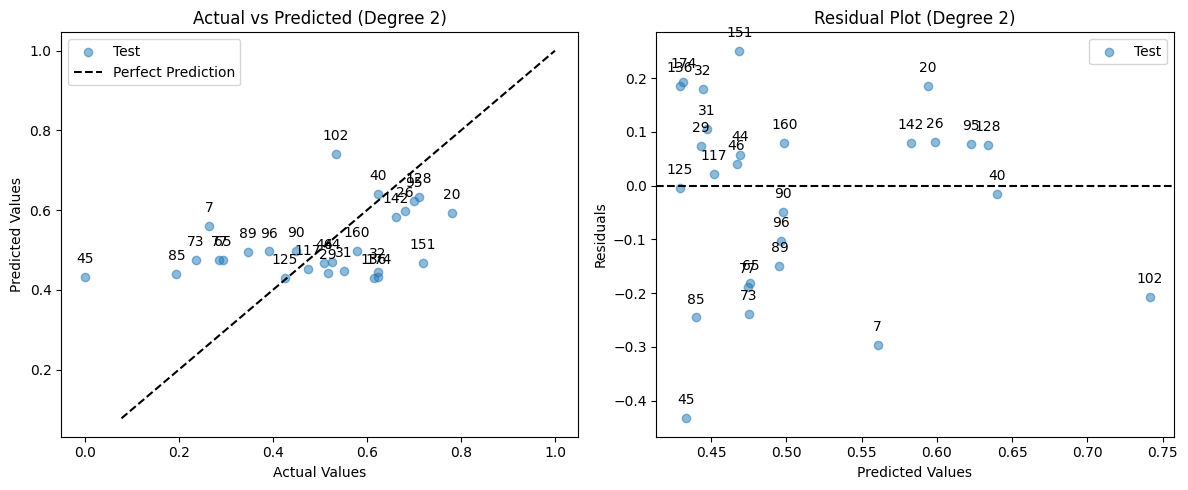

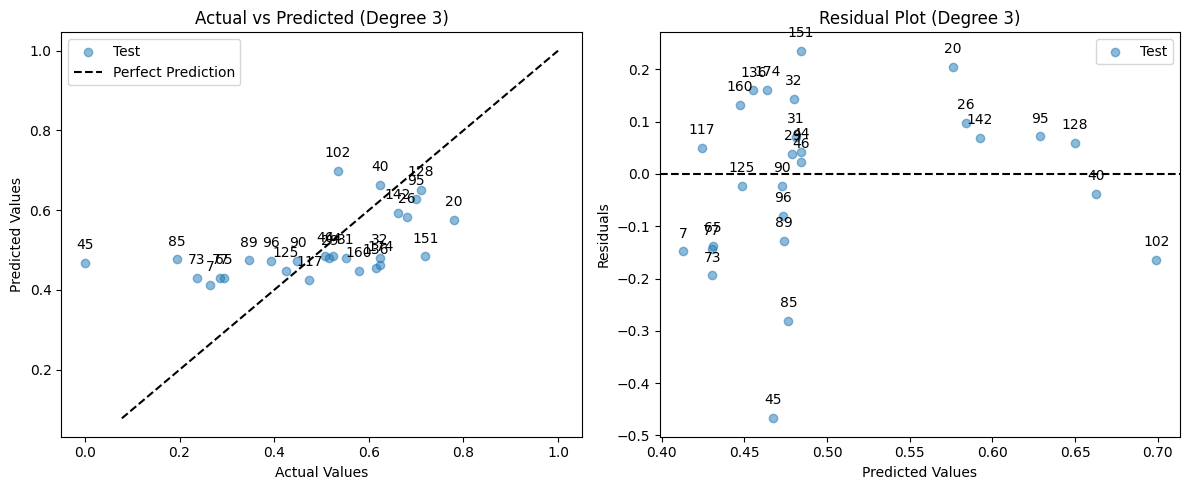

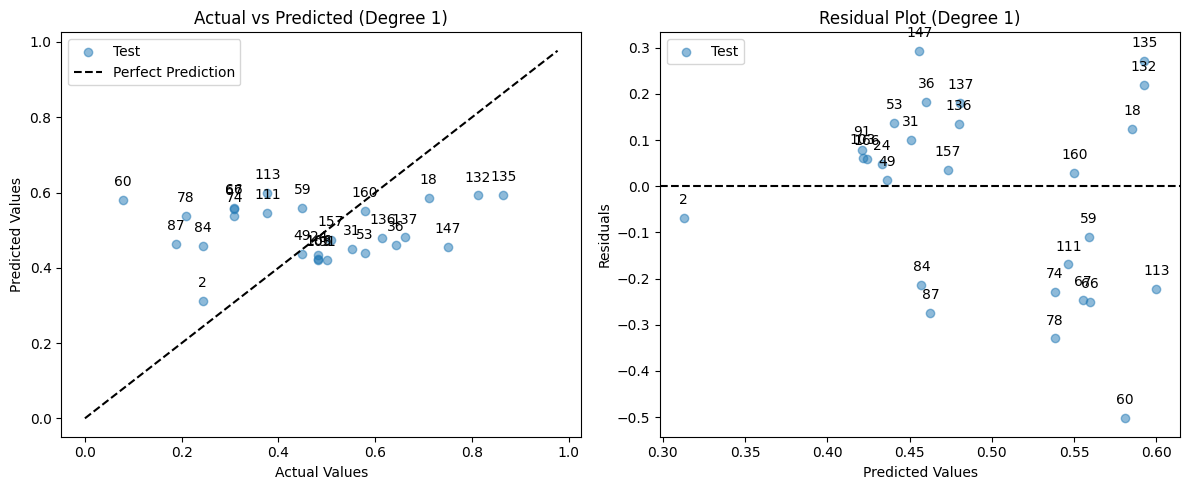

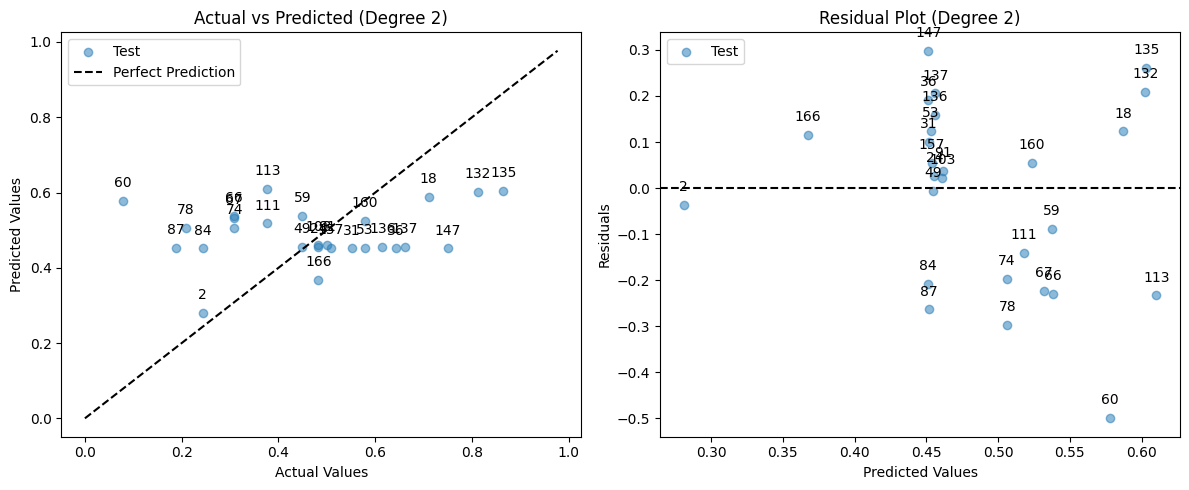

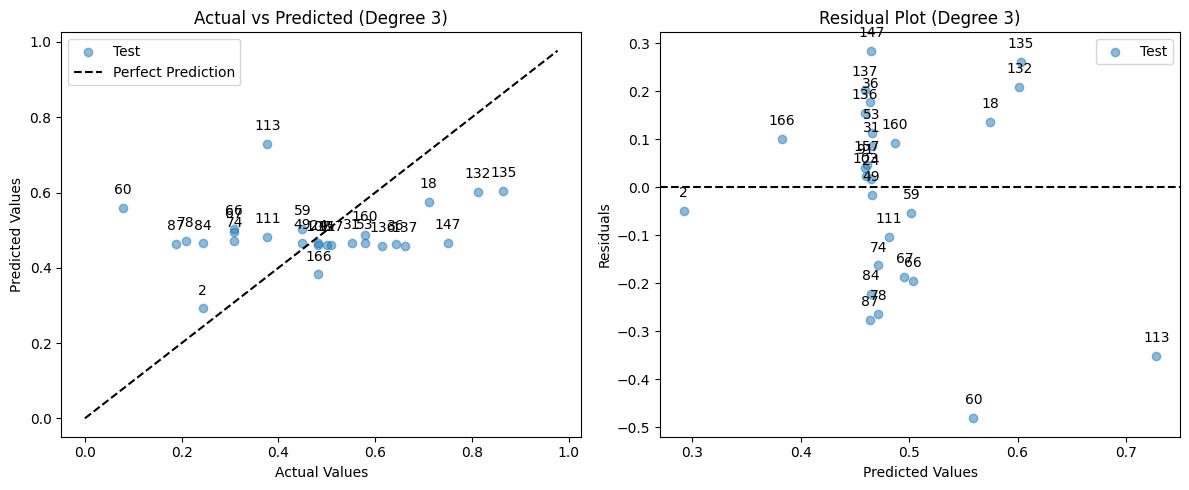

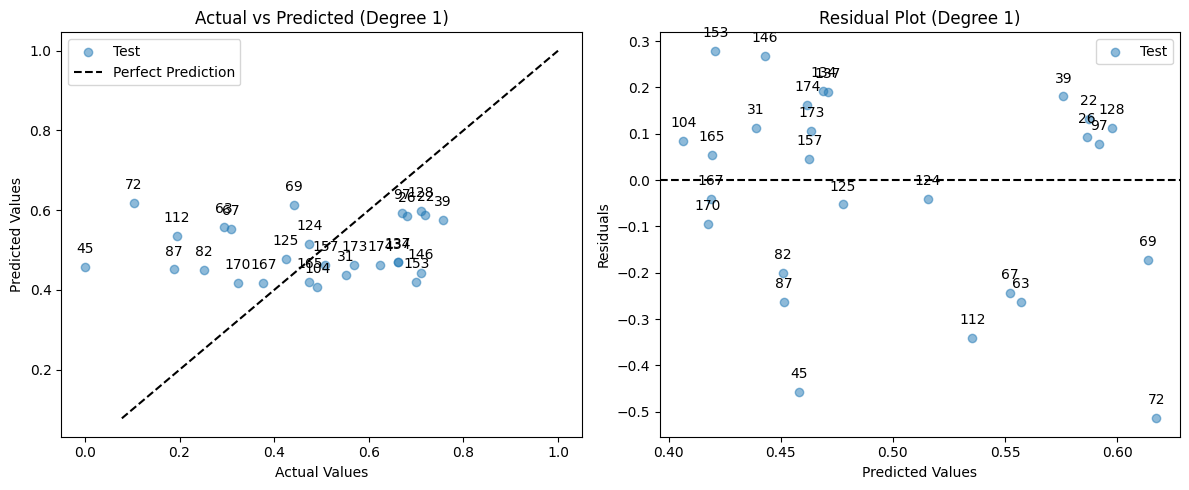

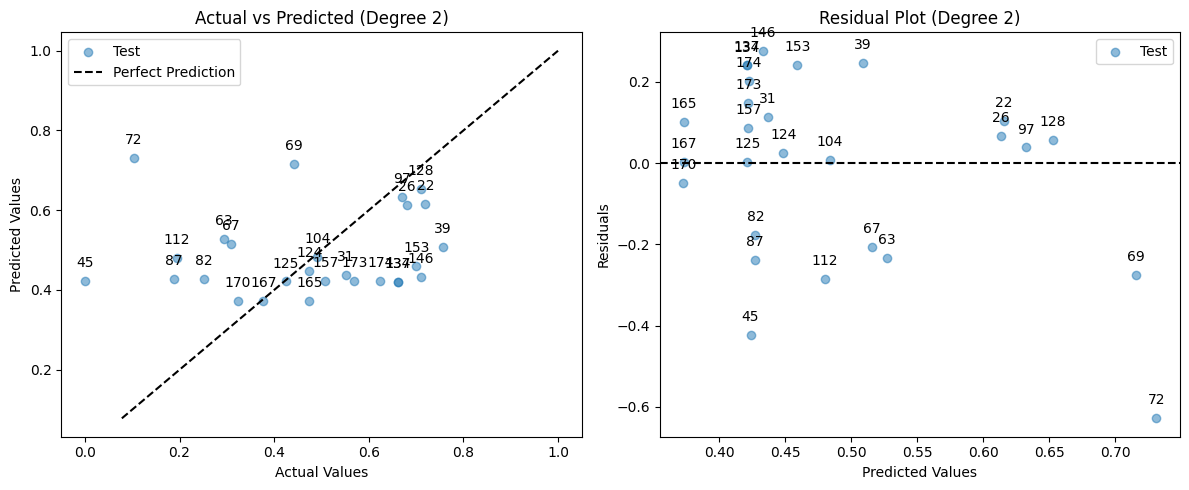

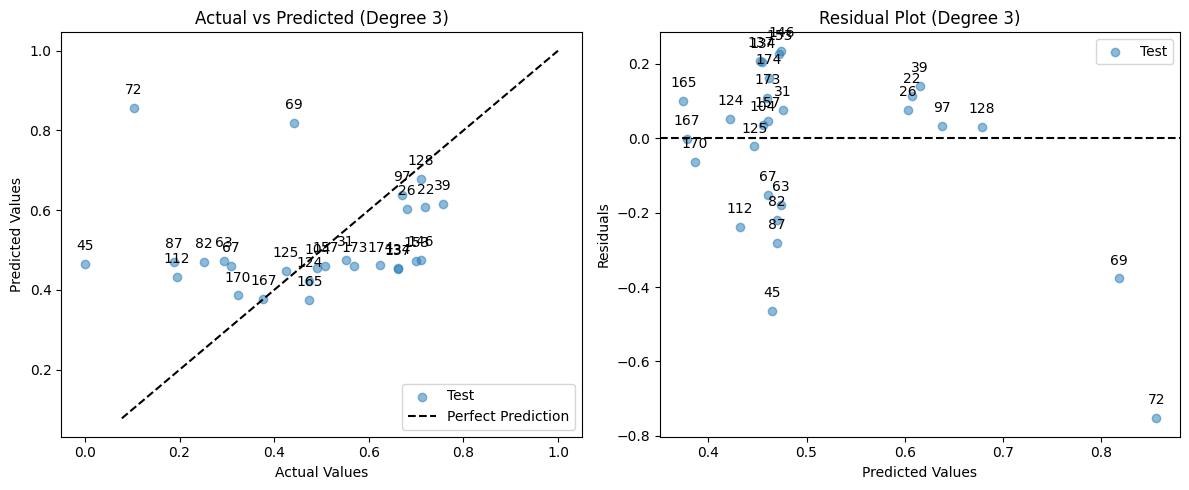

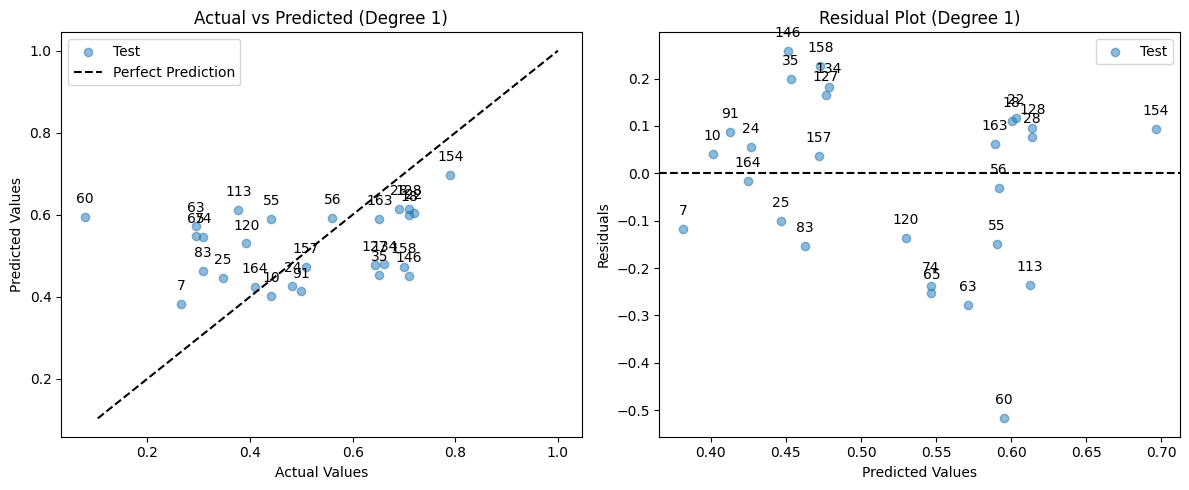

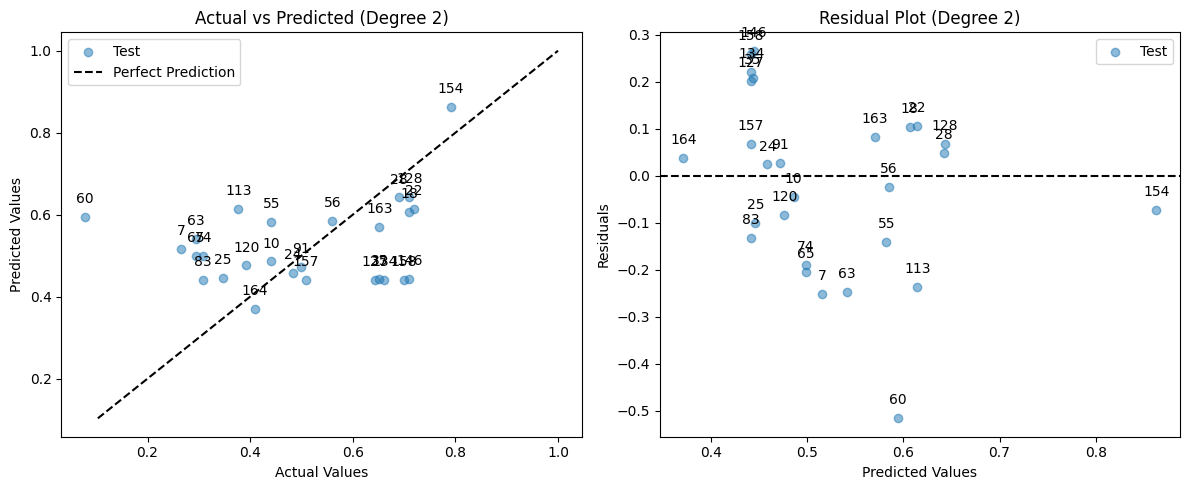

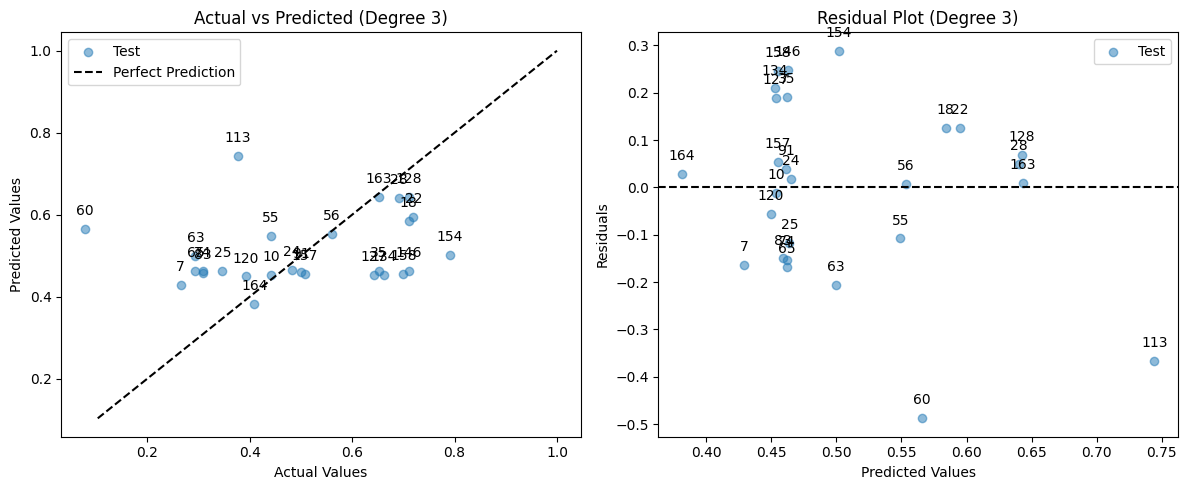

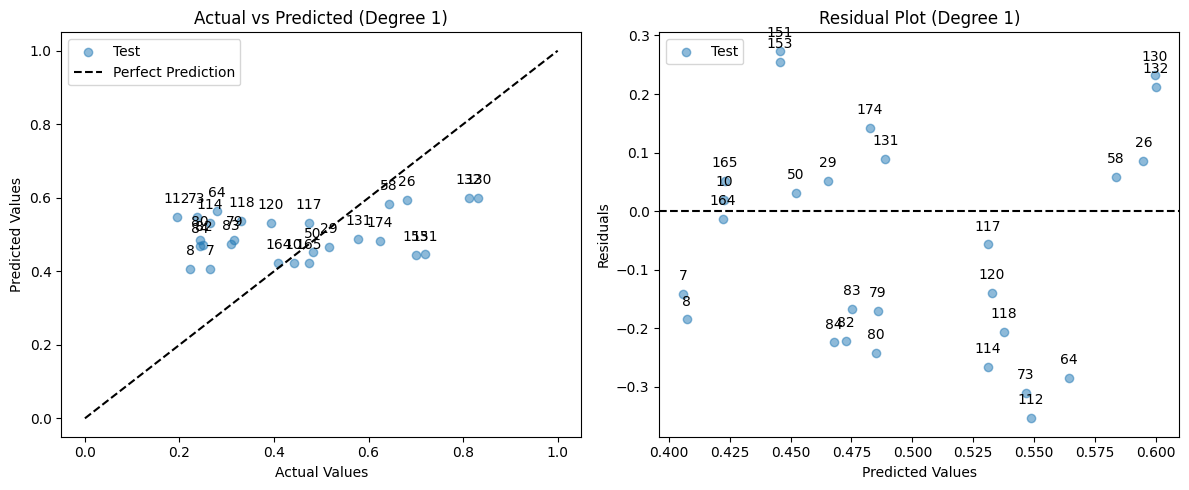

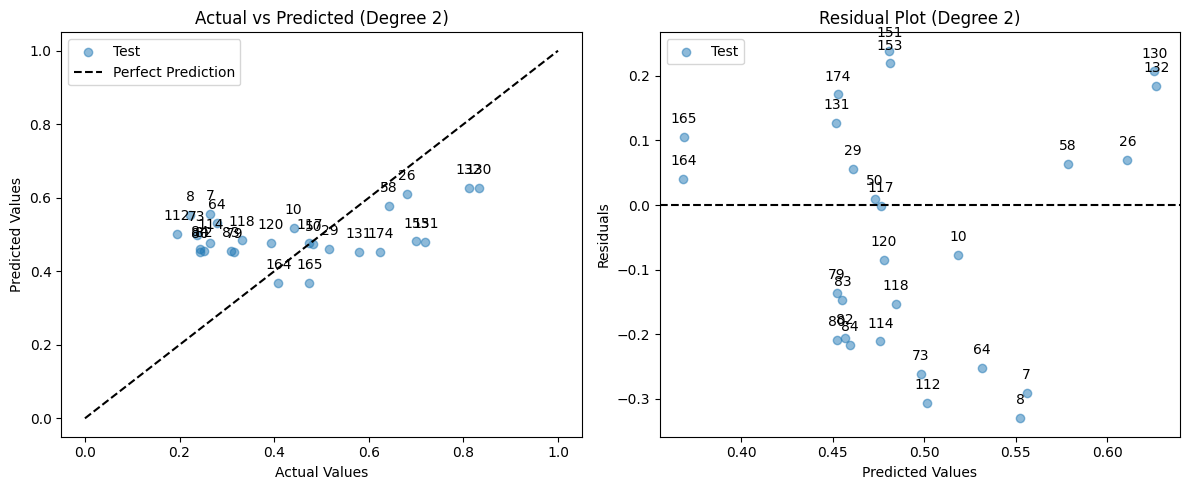

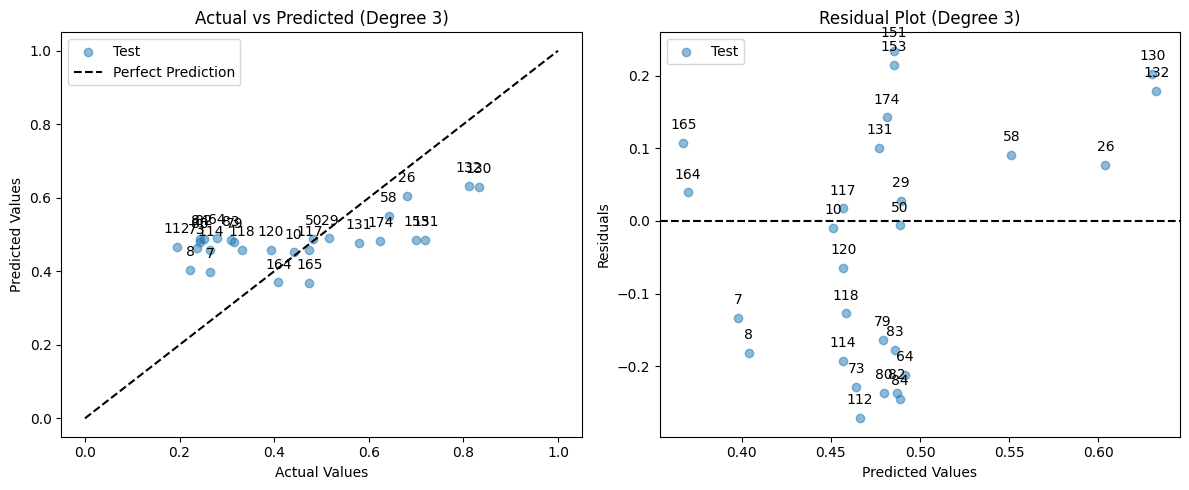


Average model performance:
        Train R2  Validation R2   Test R2  Train RMSE  Validation RMSE  Test RMSE
Degree                                                                           
1       0.202851       0.180733  0.001992    0.174826         0.155915   0.192467
2       0.267044       0.157450  0.009291    0.167609         0.157166   0.191783
3       0.320798       0.184428  0.055451    0.161275         0.153783   0.186701


In [23]:
# Running the multivariate regression model
df = loc_based_multivar_reg

all_results = []

for random_state in random_states:
    results = run_multivariate_analysis(
        df=df,
        random_state=random_state,
        target_column=target_column,
        degrees=degrees,
        k=k_folds,
        train_size=train_size,
        val_size=val_size,
        test_size=test_size
    )
    all_results.append(results)

averaged_results = pd.concat(all_results).groupby('Degree').mean()

print("\nAverage model performance:")
print(averaged_results.to_string())

## Regression analysis 2: Additional features based regression

### Prepare dataset for regression analysis

In [24]:
# Garmin activities joined with additional features data frame
garmin_activities_prep['datum'] = pd.to_datetime(garmin_activities_prep['datum'])
garmin_addfeatures_prep['datum'] = pd.to_datetime(garmin_addfeatures_prep['datum'])

# Perform left join
def join_datasets(df1, df2, cols_to_drop):
    ''' join activities and additional features datasets and drop uninformative columns'''
    
    df_total = pd.merge(
        df1,
        df2,
        on=['datum'],
        how='left')
    
    df_total.drop(cols_to_drop, axis = 1, inplace= True)

    df_total = df_total.rename(columns={'afstand_x': 'afstand'}) 

    return df_total

### Apply functions

drop_cols = ['datum','titel','afstand_y' ,'plaats', 'addfeat_sky','addfeat_winddir']

garmin_act_extended = join_datasets(garmin_activities_prep, garmin_addfeatures_prep, drop_cols)

garmin_act_extended.head()

afstand  totale_stijging  tempo_km/h  addfeat_asphalt  addfeat_forest  \
0     5.66             86.0       9.756             0.90            0.10   
1     5.53             86.0       9.704             0.90            0.10   
2     5.05             86.0       9.756             0.90            0.10   
3    11.26             15.0       9.890             0.64            0.36   
4    12.53             15.0      10.405             0.62            0.38   

   addfeat_dunes  addfeat_temp  addfeat_windsp  addfeat_humid  
0            0.0          22.2              15           0.38  
1            0.0          27.8               9           0.28  
2            0.0          31.1              11           0.38  
3            0.0          21.1              15           0.53  
4            0.0          18.9              11           0.46

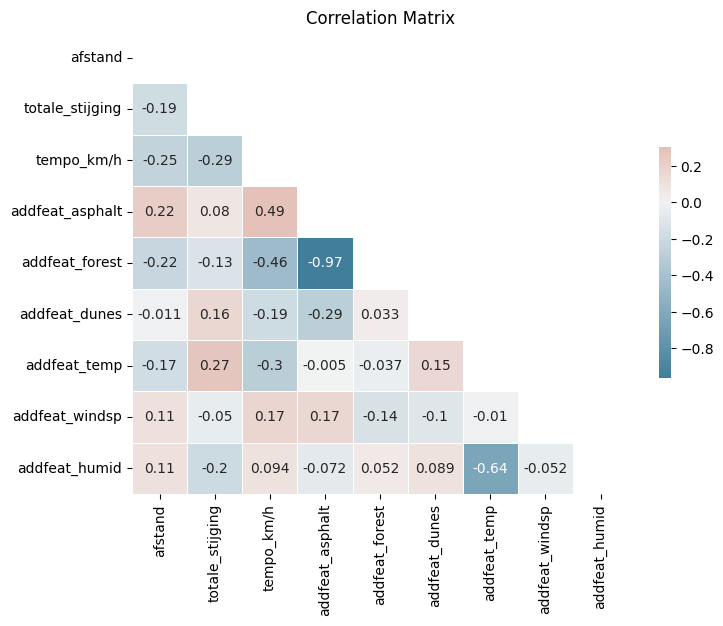

afstand  totale_stijging  tempo_km/h  addfeat_asphalt  \
afstand            1.000           -0.188      -0.252            0.217   
totale_stijging   -0.188            1.000      -0.291            0.080   
tempo_km/h        -0.252           -0.291       1.000            0.491   
addfeat_asphalt    0.217            0.080       0.491            1.000   
addfeat_forest    -0.223           -0.127      -0.460           -0.966   
addfeat_dunes     -0.011            0.160      -0.194           -0.291   
addfeat_temp      -0.167            0.265      -0.300           -0.005   
addfeat_windsp     0.110           -0.050       0.172            0.166   
addfeat_humid      0.107           -0.198       0.094           -0.072   

                 addfeat_forest  addfeat_dunes  addfeat_temp  addfeat_windsp  \
afstand                  -0.223         -0.011        -0.167           0.110   
totale_stijging          -0.127          0.160         0.265          -0.050   
tempo_km/h               -0.460         -0.194        -0.300           0.172   
addfeat_asphalt          -0.966         -0.291        -0.005           0.166   
addfeat_forest            1.000          0.033        -0.037          -0.145   
addfeat_dunes             0.033          1.000         0.152          -0.104   
addfeat_temp             -0.037          0.152         1.000          -0.010   
addfeat_windsp           -0.145         -0.104        -0.010           1.000   
addfeat_humid             0.052          0.089        -0.635          -0.052   

                 addfeat_humid  
afstand                  0.107  
totale_stijging         -0.198  
tempo_km/h               0.094  
addfeat_asphalt         -0.072  
addfeat_forest           0.052  
addfeat_dunes            0.089  
addfeat_temp            -0.635  
addfeat_windsp          -0.052  
addfeat_humid            1.000

In [25]:
# Create correlation plot
drop_cols = []

df_correlation = correlation_plot(garmin_act_extended, drop_cols)

df_correlation

### Regression analysis

In [26]:
# Filer data set based on correlation threshold

corr_treshold = 0.19
target_column = 'tempo_km/h'

addfeature_based_multivar_reg = create_reg_dataset(garmin_act_extended, df_correlation, target_column, corr_treshold)

addfeature_based_multivar_reg.head()

afstand  totale_stijging  addfeat_asphalt  addfeat_forest  addfeat_dunes  \
0  0.215926         0.736842         0.888889        0.111111            0.0   
1  0.205972         0.736842         0.888889        0.111111            0.0   
2  0.169219         0.736842         0.888889        0.111111            0.0   
3  0.644717         0.114035         0.600000        0.400000            0.0   
4  0.741960         0.114035         0.577778        0.422222            0.0   

   addfeat_temp  tempo_km/h  
0      0.732733    0.243453  
1      0.900901    0.229556  
2      1.000000    0.243453  
3      0.699700    0.279262  
4      0.633634    0.416889

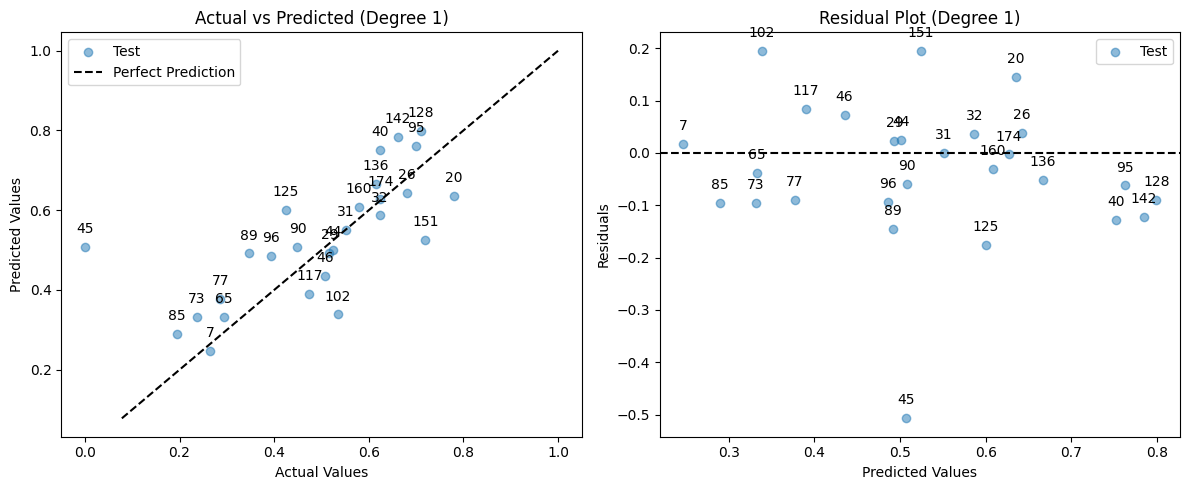

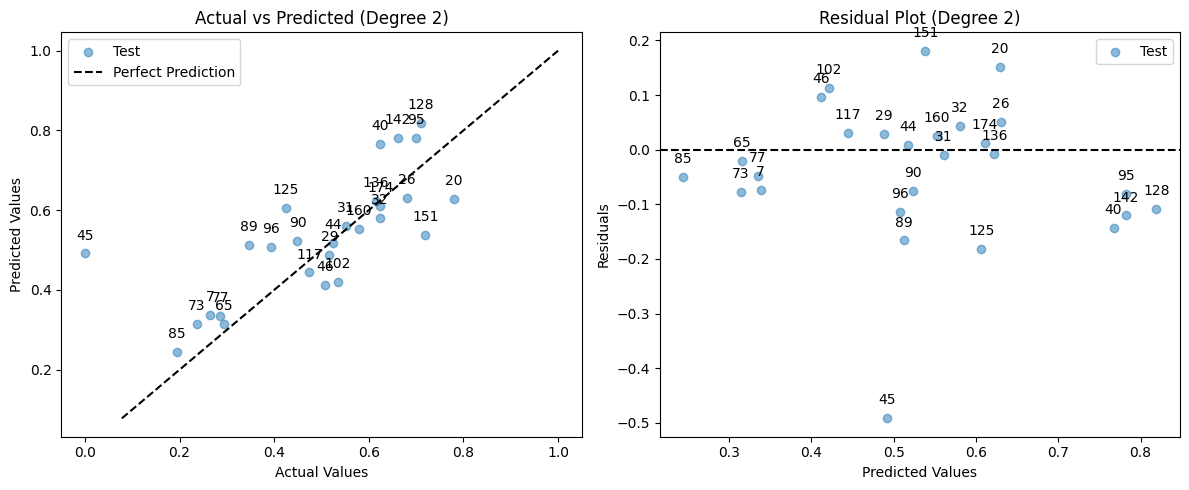

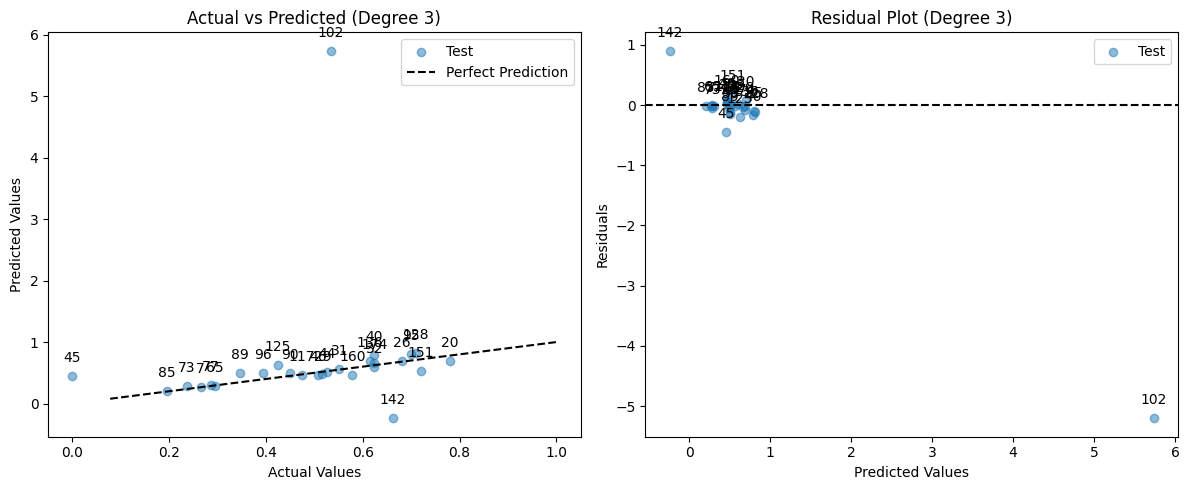

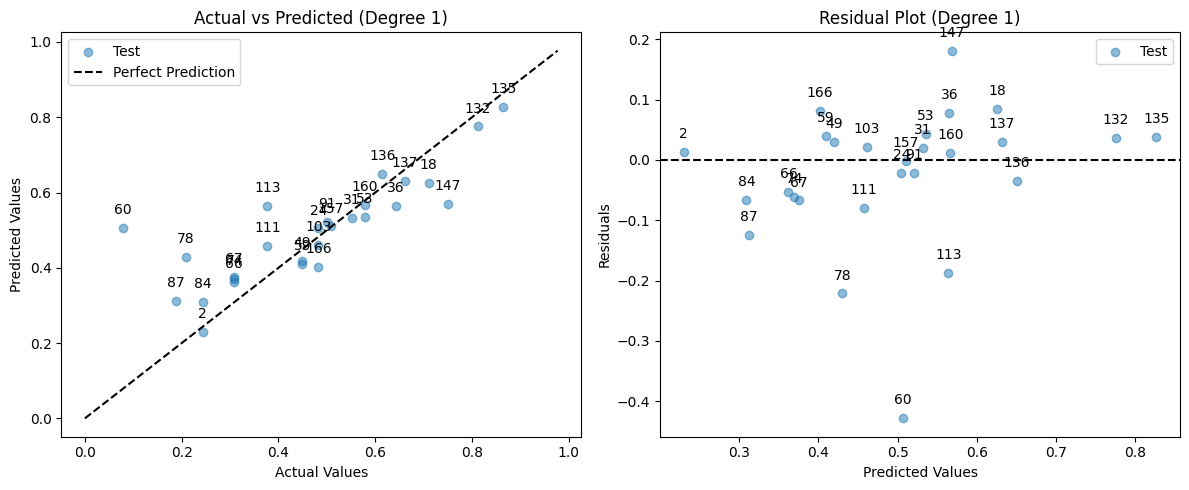

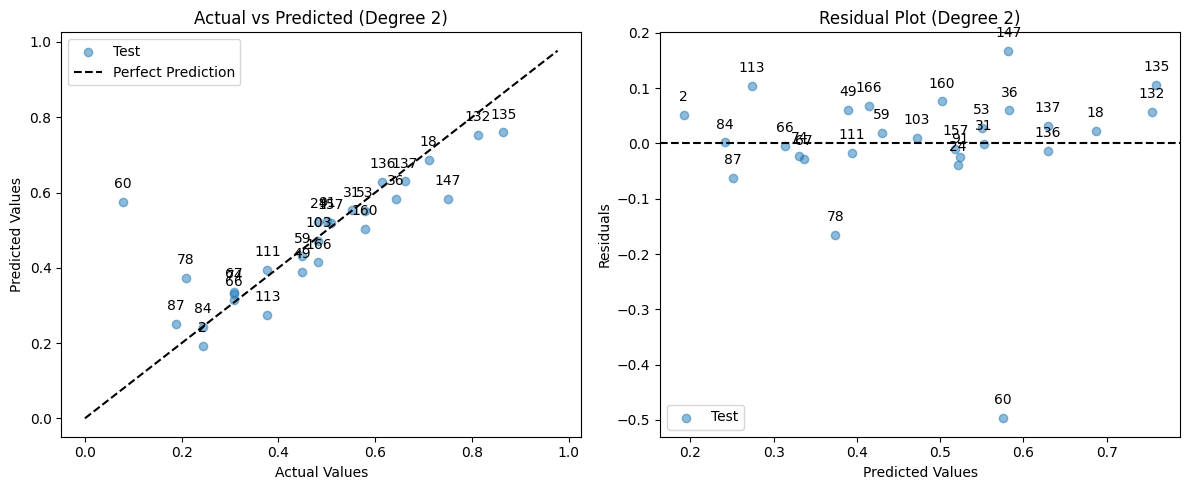

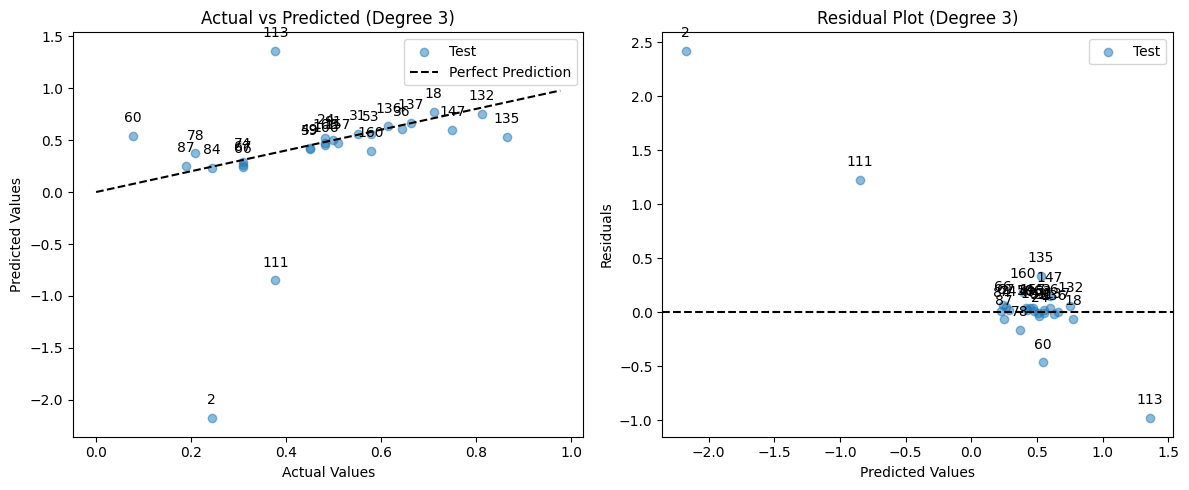

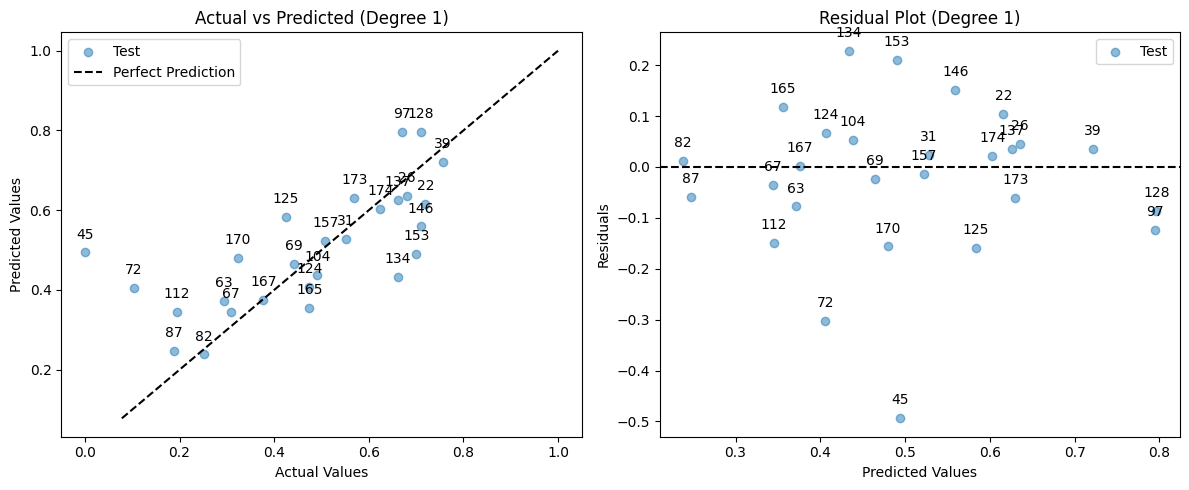

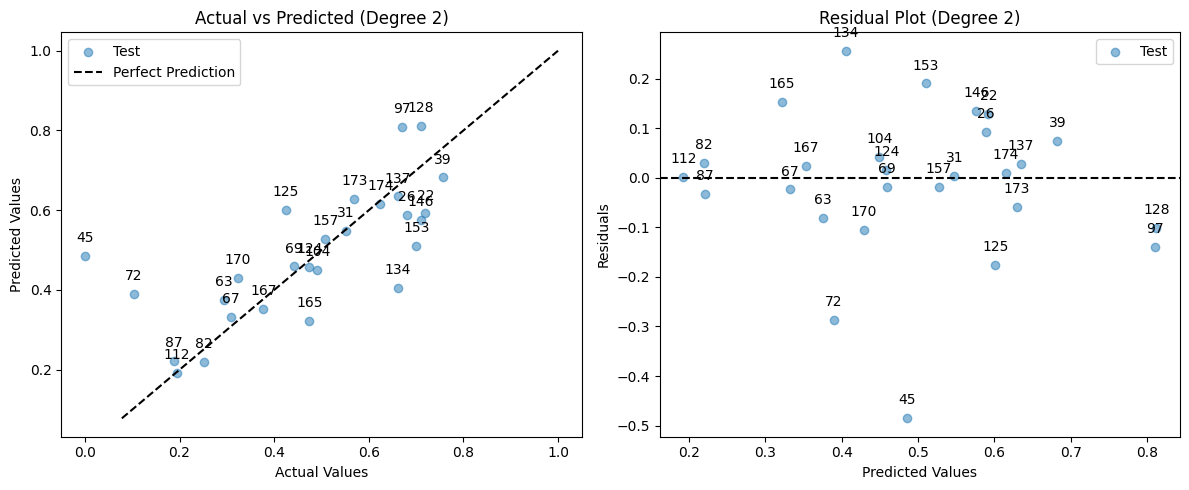

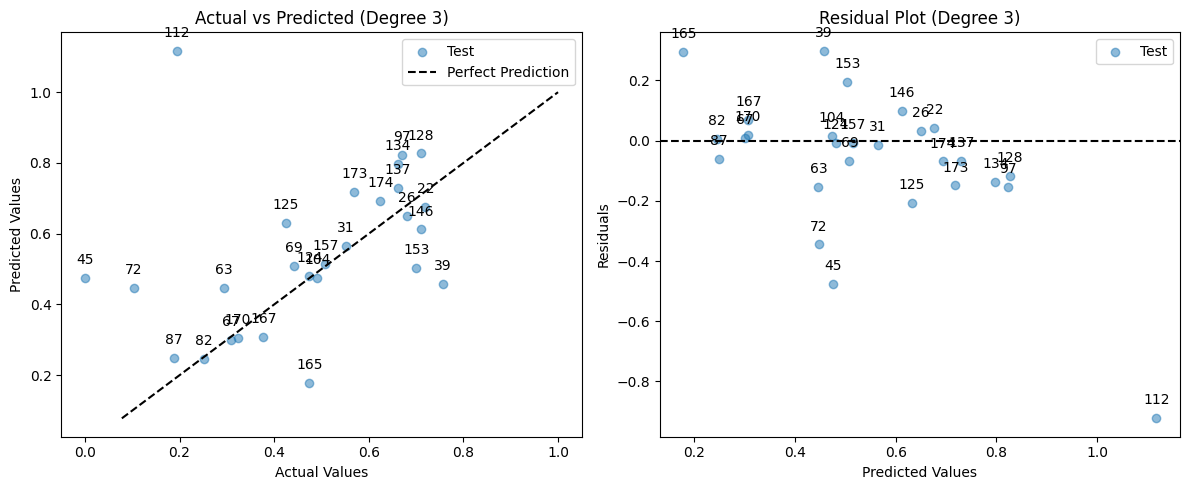

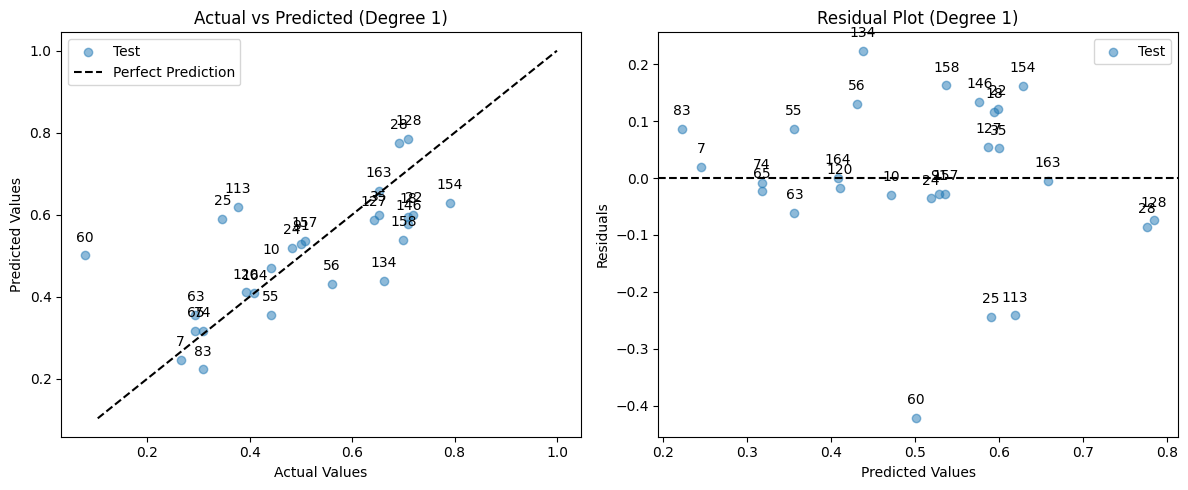

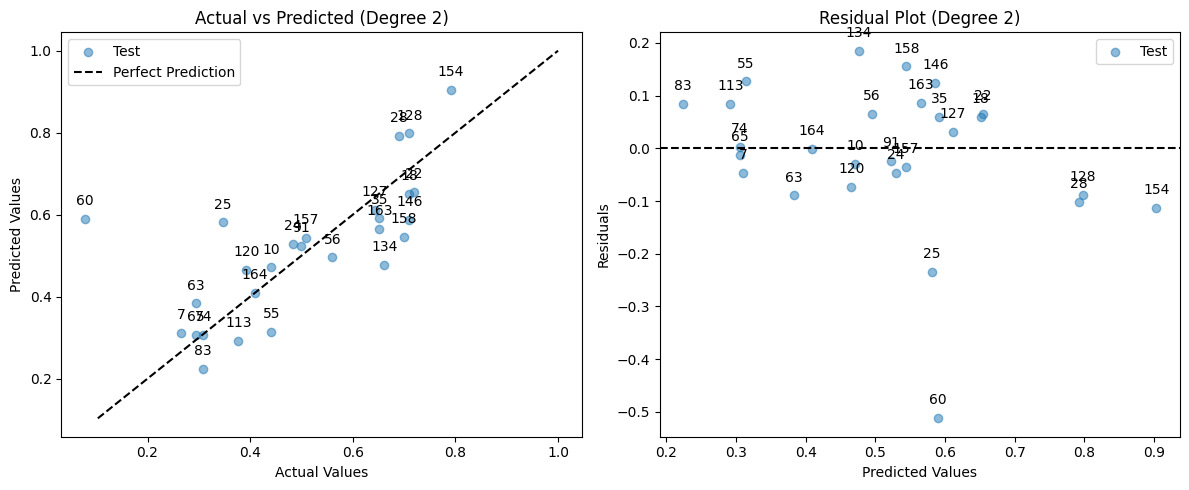

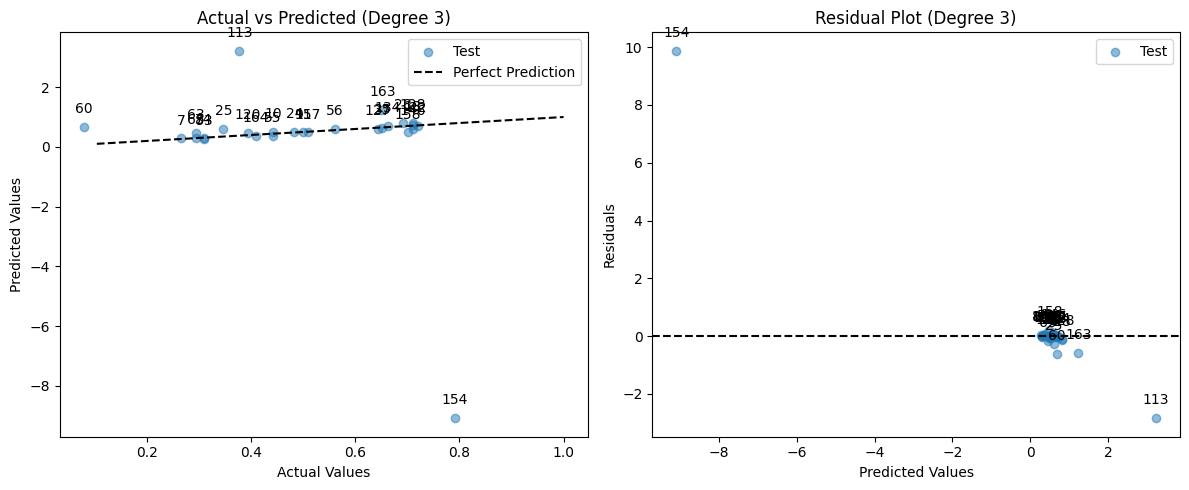

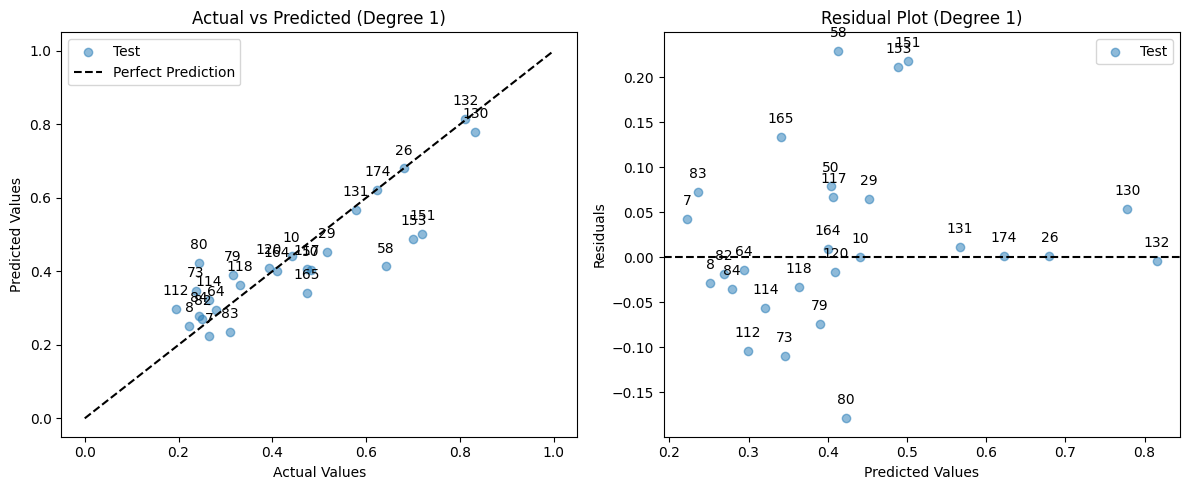

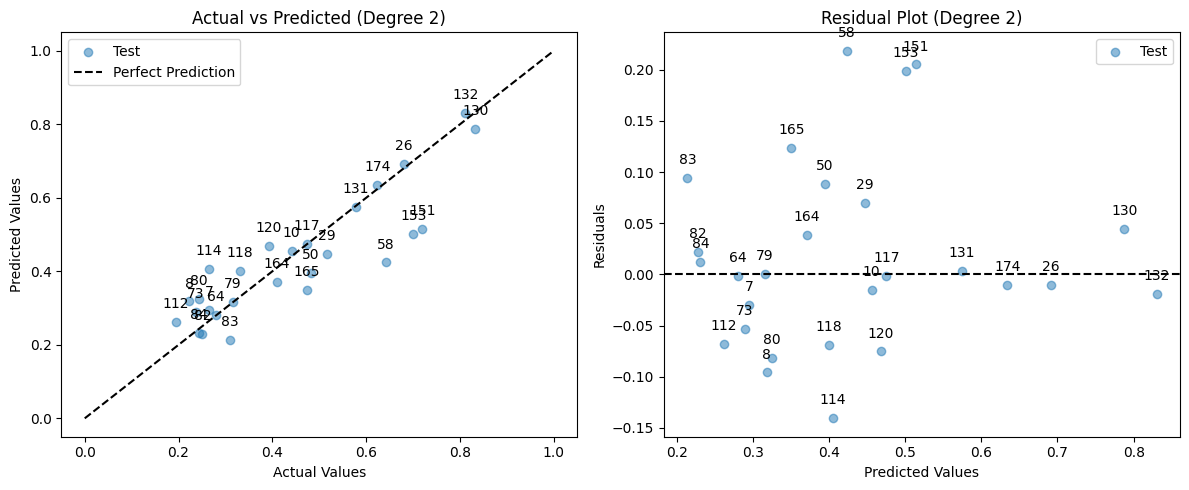

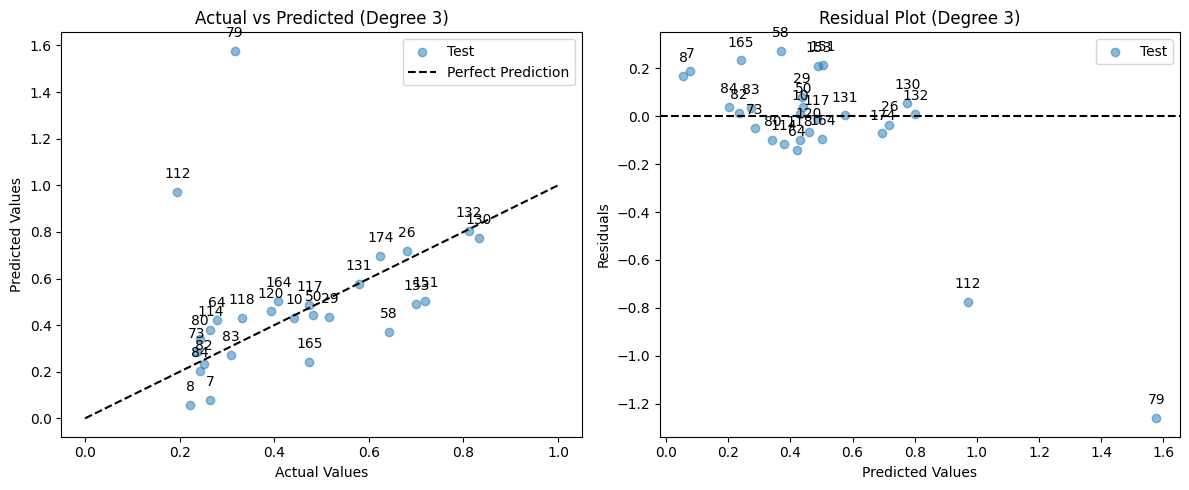


Average model performance:
        Train R2  Validation R2    Test R2  Train RMSE  Validation RMSE  Test RMSE
Degree                                                                            
1       0.652147       0.502850   0.551805    0.115238         0.119290   0.127511
2       0.712607       0.489333   0.572485    0.104762         0.121278   0.124333
3       0.789231   -2767.961824 -31.344489    0.089654         4.589470   0.826127


In [27]:
# Running the multivariate regression model
df = addfeature_based_multivar_reg

all_results = []

for random_state in random_states:
    results = run_multivariate_analysis(
        df=df,
        random_state=random_state,
        target_column=target_column,
        degrees=degrees,
        k=k_folds,
        train_size=train_size,
        val_size=val_size,
        test_size=test_size
    )
    all_results.append(results)

averaged_results = pd.concat(all_results).groupby('Degree').mean()

print("\nAverage model performance:")
print(averaged_results.to_string())

# End of notebook